In [18]:
import os
import sys
sys.path.insert(0, './../')
import bbdc2021 as bbdc

In [19]:
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [20]:
def pipeline_u_net_1(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block1(pipe_param)
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block1_unet(x_tv, y_tv, unet_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

In [21]:
def cross_val(pipeline, pipeparam, modelparam, testindexlist):
    """Cross validates a given pipepline."""
    all_scores_list = []
    all_model_psds = []
    all_pp_psds = []
    for indices in testindexlist:
        pipe_param['test_split_range'] = indices
        print('Test Split:', indices)
        scores_list, model_psds, pp_psds = pipeline(pipeparam, modelparam)
        all_scores_list.append(scores_list)
        all_model_psds.append(model_psds)
        all_pp_psds.append(pp_psds)
        print('\n\n\n')
    fold = len(test_index_list)
    print('Cross validation summary:')
    print('Loss ', [elem[0] for elem in all_scores_list])
    print('Mean Loss', sum([elem[0] for elem in all_scores_list])/fold)
    print('')
    print('MAE', [elem[1] for elem in all_scores_list])
    print('Mean MAE', sum([elem[1] for elem in all_scores_list])/fold)
    print('')
    print('Accuracy', [elem[2] for elem in all_scores_list])
    print('Mean Accuracy', sum([elem[2] for elem in all_scores_list])/fold)
    print('')
    print('Model PSDS', all_model_psds)
    print('Mean model PSDS', sum(all_model_psds)/fold)
    print('')
    print('Post processed PSDS', all_pp_psds)
    print('Mean Post processed PSDS', sum(all_pp_psds)/fold)

# Cross validation for submission1 file

Test Split: (0, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 40s 66ms/step - loss: 1.5457 - mae: 0.0927 - accuracy: 0.5899 - val_loss: 2.5895 - val_mae: 0.1201 - val_accuracy: 0.2933

Epoch 00001: val_loss improved from inf to 2.58950, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 30s 63ms/step - loss: 0.8088 - mae: 0.0514 - accuracy: 0.7598 - val_loss: 3.8230 - val_mae: 0.1294 - val_accuracy: 0.1775

Epoch 00002: val_loss did not improve from 2.58950
Epoch 3/100
475/475 [==============================] - 30s 63ms/step - loss: 0.6666 - mae: 0.0434 - accuracy: 0.8016 - val_loss: 4.6626 - val_mae: 0.1294 - val_accuracy: 0.1726

Epoch 00003: val_loss did not improve from 2.58950
Epoch 4/100
475/475 [===

475/475 [==============================] - 28s 58ms/step - loss: 0.2364 - mae: 0.0167 - accuracy: 0.9274 - val_loss: 3.9317 - val_mae: 0.1060 - val_accuracy: 0.3205

Epoch 00035: val_loss did not improve from 0.53818
Epoch 36/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2409 - mae: 0.0167 - accuracy: 0.9259 - val_loss: 3.6982 - val_mae: 0.1075 - val_accuracy: 0.3119

Epoch 00036: val_loss did not improve from 0.53818
Epoch 37/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2134 - mae: 0.0152 - accuracy: 0.9343 - val_loss: 2.3057 - val_mae: 0.0880 - val_accuracy: 0.4464

Epoch 00037: val_loss did not improve from 0.53818
Epoch 38/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2168 - mae: 0.0153 - accuracy: 0.9327 - val_loss: 1.9059 - val_mae: 0.0744 - val_accuracy: 0.5472

Epoch 00038: val_loss did not improve from 0.53818
Epoch 39/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2171 - mae: 0


Epoch 00070: val_loss did not improve from 0.37932
Epoch 71/100
475/475 [==============================] - 27s 57ms/step - loss: 0.1945 - mae: 0.0135 - accuracy: 0.9400 - val_loss: 3.3960 - val_mae: 0.0916 - val_accuracy: 0.4113

Epoch 00071: val_loss did not improve from 0.37932
Epoch 72/100
475/475 [==============================] - 27s 58ms/step - loss: 0.1581 - mae: 0.0115 - accuracy: 0.9499 - val_loss: 1.5040 - val_mae: 0.0610 - val_accuracy: 0.6377

Epoch 00072: val_loss did not improve from 0.37932
Epoch 73/100
475/475 [==============================] - 31s 65ms/step - loss: 0.1879 - mae: 0.0133 - accuracy: 0.9411 - val_loss: 7.3148 - val_mae: 0.1253 - val_accuracy: 0.1881

Epoch 00073: val_loss did not improve from 0.37932
Epoch 74/100
475/475 [==============================] - 31s 66ms/step - loss: 0.1922 - mae: 0.0137 - accuracy: 0.9402 - val_loss: 0.4333 - val_mae: 0.0237 - val_accuracy: 0.8806

Epoch 00074: val_loss did not improve from 0.37932
Epoch 75/100
475/475 [======

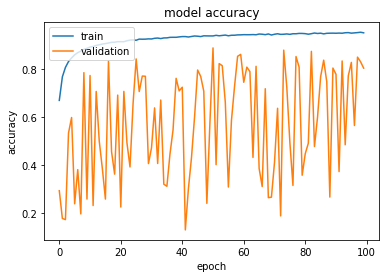

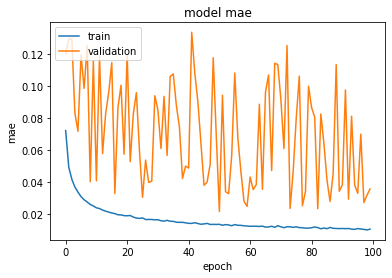

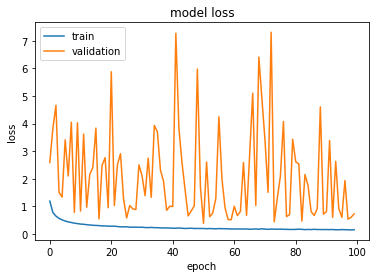

63/63 [==============================] - 2s 24ms/step - loss: 0.7315 - mae: 0.0359 - accuracy: 0.8061

Evaluation:
Loss, MAE, Accuracy [0.7315242886543274, 0.035944677889347076, 0.8061140775680542]
PSDS (0.06383967876584747, 'Valid file')

Filling post processing used.
PSDS (0.45965378737457535, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 52s 73ms/step - loss: 1.4489 - mae: 0.0870 - accuracy: 0.5991 - val_loss: 2.3277 - val_mae: 0.1211 - val_accuracy: 0.2703

Epoch 00001: val_loss improved from inf to 2.32775, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 27s 58ms/step - loss: 0.8247 - mae: 0.0522 - accuracy: 0.7538 - val_loss: 1.8235 - val_mae: 0.0955 - val_accuracy: 0.4598

Epoch 00002: val_loss improved from 2.32775 to 1.82355, saving model to model.h5
Epoch 3/100
475/475 [==============================] - 26s 54ms/step - loss: 0.6752 - mae: 0.0441 - accuracy: 0.7949 - val_loss: 1.4894 - val_mae: 0.0871 - val_a

475/475 [==============================] - 29s 60ms/step - loss: 0.2699 - mae: 0.0187 - accuracy: 0.9173 - val_loss: 2.6487 - val_mae: 0.0940 - val_accuracy: 0.4088

Epoch 00034: val_loss did not improve from 0.60361
Epoch 35/100
475/475 [==============================] - 32s 67ms/step - loss: 0.2470 - mae: 0.0174 - accuracy: 0.9242 - val_loss: 0.6539 - val_mae: 0.0367 - val_accuracy: 0.8135

Epoch 00035: val_loss did not improve from 0.60361
Epoch 36/100
475/475 [==============================] - 30s 63ms/step - loss: 0.2179 - mae: 0.0156 - accuracy: 0.9324 - val_loss: 0.6526 - val_mae: 0.0324 - val_accuracy: 0.8262

Epoch 00036: val_loss did not improve from 0.60361
Epoch 37/100
475/475 [==============================] - 26s 56ms/step - loss: 0.2303 - mae: 0.0163 - accuracy: 0.9285 - val_loss: 4.4478 - val_mae: 0.1116 - val_accuracy: 0.2830

Epoch 00037: val_loss did not improve from 0.60361
Epoch 38/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2256 - mae: 0

475/475 [==============================] - 29s 61ms/step - loss: 0.1820 - mae: 0.0130 - accuracy: 0.9425 - val_loss: 1.4340 - val_mae: 0.0623 - val_accuracy: 0.6293

Epoch 00069: val_loss did not improve from 0.47433
Epoch 70/100
475/475 [==============================] - 29s 61ms/step - loss: 0.1849 - mae: 0.0134 - accuracy: 0.9419 - val_loss: 1.1194 - val_mae: 0.0516 - val_accuracy: 0.6990

Epoch 00070: val_loss did not improve from 0.47433
Epoch 71/100
475/475 [==============================] - 29s 61ms/step - loss: 0.1809 - mae: 0.0130 - accuracy: 0.9428 - val_loss: 0.4210 - val_mae: 0.0202 - val_accuracy: 0.8883

Epoch 00071: val_loss improved from 0.47433 to 0.42104, saving model to model.h5
Epoch 72/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1665 - mae: 0.0121 - accuracy: 0.9473 - val_loss: 0.5165 - val_mae: 0.0226 - val_accuracy: 0.8757

Epoch 00072: val_loss did not improve from 0.42104
Epoch 73/100
475/475 [==============================] - 28s 58m

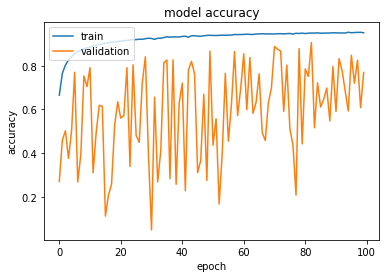

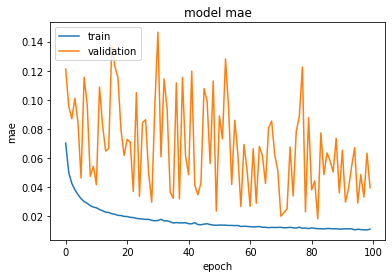

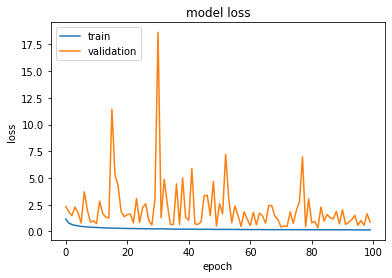

63/63 [==============================] - 2s 26ms/step - loss: 0.9047 - mae: 0.0400 - accuracy: 0.7677

Evaluation:
Loss, MAE, Accuracy [0.9047466516494751, 0.040009915828704834, 0.7677249908447266]
PSDS (0.09935546495913834, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 1 file(s) missing, e.g. ['03055_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 40s 70ms/step - loss: 1.5518 - mae: 0.0928 - accuracy: 0.5778 - val_loss: 3.2894 - val_mae: 0.1351 - val_accuracy: 0.1289

Epoch 00001: val_loss improved from inf to 3.28941, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 30s 63ms/step - loss: 0.8511 - mae: 0.0541 - accuracy: 0.7448 - val_loss: 6.1696 - val_mae: 0.1303 - val_accuracy: 0.1724

Epoch 00002: val_loss did not improve from 3.28941
Epoch 3/100
475/475 [==============================] - 30s 63ms/step - loss: 0.6831 - mae: 0.0446 - accuracy: 0.7944 - val_loss: 5.2981 - val_mae: 0.1339 - val_accuracy: 0.1330

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.66242
Epoch 35/100
475/475 [==============================] - 30s 64ms/step - loss: 0.2443 - mae: 0.0171 - accuracy: 0.9247 - val_loss: 0.7698 - val_mae: 0.0394 - val_accuracy: 0.7825

Epoch 00035: val_loss did not improve from 0.66242
Epoch 36/100
475/475 [==============================] - 31s 65ms/step - loss: 0.2212 - mae: 0.0156 - accuracy: 0.9317 - val_loss: 0.7300 - val_mae: 0.0344 - val_accuracy: 0.8165

Epoch 00036: val_loss did not improve from 0.66242
Epoch 37/100
475/475 [==============================] - 29s 61ms/step - loss: 0.2273 - mae: 0.0160 - accuracy: 0.9296 - val_loss: 0.6123 - val_mae: 0.0392 - val_accuracy: 0.8118

Epoch 00037: val_loss improved from 0.66242 to 0.61228, saving model to model.h5
Epoch 38/100
475/475 [==============================] - 26s 55ms/step - loss: 0.2165 - mae: 0.0155 - accuracy: 0.9325 - val_loss: 2.3228 - val_mae: 0.0872 - val_accuracy: 0.4466

Epoch 00038: val_loss did not improve from 0.6122

475/475 [==============================] - 28s 59ms/step - loss: 0.1803 - mae: 0.0131 - accuracy: 0.9432 - val_loss: 0.9566 - val_mae: 0.0459 - val_accuracy: 0.7355

Epoch 00070: val_loss did not improve from 0.52407
Epoch 71/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1740 - mae: 0.0125 - accuracy: 0.9456 - val_loss: 0.3035 - val_mae: 0.0168 - val_accuracy: 0.9133

Epoch 00071: val_loss improved from 0.52407 to 0.30349, saving model to model.h5
Epoch 72/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1676 - mae: 0.0121 - accuracy: 0.9472 - val_loss: 7.0811 - val_mae: 0.1269 - val_accuracy: 0.1788

Epoch 00072: val_loss did not improve from 0.30349
Epoch 73/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1762 - mae: 0.0126 - accuracy: 0.9447 - val_loss: 1.4790 - val_mae: 0.0612 - val_accuracy: 0.6308

Epoch 00073: val_loss did not improve from 0.30349
Epoch 74/100
475/475 [==============================] - 28s 58m

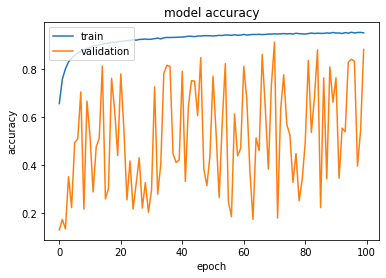

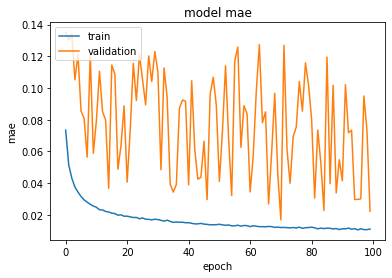

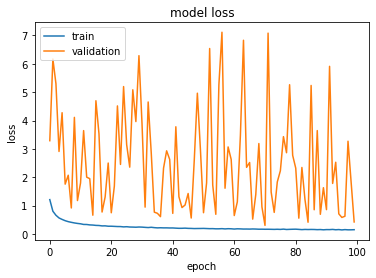

63/63 [==============================] - 2s 24ms/step - loss: 0.4252 - mae: 0.0223 - accuracy: 0.8820

Evaluation:
Loss, MAE, Accuracy [0.42524805665016174, 0.022327791899442673, 0.8820078372955322]
PSDS (0.09746690807811459, 'Valid file')

Filling post processing used.
PSDS (0.7099699615152879, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
475/475 [==============================] - 45s 71ms/step - loss: 1.4816 - mae: 0.0887 - accuracy: 0.5961 - val_loss: 5.0183 - val_mae: 0.1350 - val_accuracy: 0.1390

Epoch 00001: val_loss improved from inf to 5.01828, saving model to model.h5
Epoch 2/100
475/475 [==============================] - 31s 64ms/step - loss: 0.8227 - mae: 0.0518 - accuracy: 0.7560 - val_loss: 2.6425 - val_mae: 0.1130 - val_accuracy: 0.2940

Epoch 00002: val_loss improved from 5.01828 to 2.64249, saving model to model.h5
Epoch 3/100
475/475 [==============================] - 31s 66ms/step - loss: 0.6520 - mae: 0.0427 - accuracy: 0.8033 - val_loss: 1.8796 - val_mae: 0.0899 - val_a


Epoch 00034: val_loss did not improve from 0.59222
Epoch 35/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2388 - mae: 0.0170 - accuracy: 0.9257 - val_loss: 2.0407 - val_mae: 0.0767 - val_accuracy: 0.5325

Epoch 00035: val_loss did not improve from 0.59222
Epoch 36/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2438 - mae: 0.0170 - accuracy: 0.9253 - val_loss: 1.0129 - val_mae: 0.0434 - val_accuracy: 0.7552

Epoch 00036: val_loss did not improve from 0.59222
Epoch 37/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2338 - mae: 0.0166 - accuracy: 0.9275 - val_loss: 0.5263 - val_mae: 0.0258 - val_accuracy: 0.8571

Epoch 00037: val_loss improved from 0.59222 to 0.52627, saving model to model.h5
Epoch 38/100
475/475 [==============================] - 28s 59ms/step - loss: 0.2097 - mae: 0.0151 - accuracy: 0.9345 - val_loss: 3.4440 - val_mae: 0.1107 - val_accuracy: 0.2860

Epoch 00038: val_loss did not improve from 0.5262

475/475 [==============================] - 28s 58ms/step - loss: 0.1766 - mae: 0.0127 - accuracy: 0.9447 - val_loss: 1.4533 - val_mae: 0.0696 - val_accuracy: 0.5854

Epoch 00070: val_loss did not improve from 0.37153
Epoch 71/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1635 - mae: 0.0118 - accuracy: 0.9490 - val_loss: 1.1132 - val_mae: 0.0408 - val_accuracy: 0.7678

Epoch 00071: val_loss did not improve from 0.37153
Epoch 72/100
475/475 [==============================] - 28s 58ms/step - loss: 0.1791 - mae: 0.0129 - accuracy: 0.9435 - val_loss: 0.4580 - val_mae: 0.0231 - val_accuracy: 0.8775

Epoch 00072: val_loss did not improve from 0.37153
Epoch 73/100
475/475 [==============================] - 28s 58ms/step - loss: 0.2134 - mae: 0.0145 - accuracy: 0.9351 - val_loss: 1.4738 - val_mae: 0.0590 - val_accuracy: 0.6536

Epoch 00073: val_loss did not improve from 0.37153
Epoch 74/100
475/475 [==============================] - 28s 59ms/step - loss: 0.1861 - mae: 0

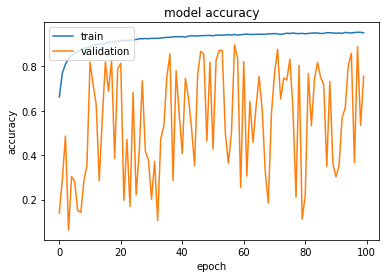

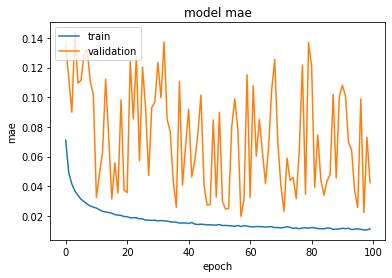

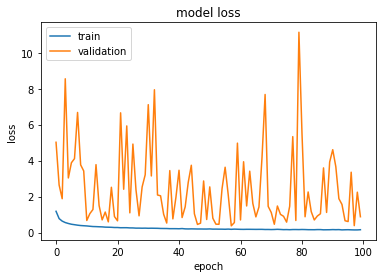

63/63 [==============================] - 2s 24ms/step - loss: 0.9003 - mae: 0.0426 - accuracy: 0.7551

Evaluation:
Loss, MAE, Accuracy [0.9003149271011353, 0.042586326599121094, 0.755078136920929]
PSDS (0.16418473692249985, 'Valid file')

Filling post processing used.
PSDS (0.5071703478616282, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [==============================] - 50s 65ms/step - loss: 1.3992 - mae: 0.0846 - accuracy: 0.6200 - val_loss: 4.1076 - val_mae: 0.1270 - val_accuracy: 0.1855

Epoch 00001: val_loss improved from inf to 4.10759, saving model to model.h5
Epoch 2/100
593/593 [==============================] - 35s 59ms/step - loss: 0.7627 - mae: 0.0490 - accuracy: 0.7735 - val_loss: 4.3161 - val_mae: 0.1279 - val_accuracy: 0.1735

Epoch 00002: val_loss did not improve from 4.10759
Epoch 3/100
593/593 [==============================] - 34s 58ms/step - loss: 0.6030 - mae: 0.0397 - accuracy: 0.8207 - val_loss: 4.1103 - val_mae: 0.1206 - val_accuracy: 0.2225

Epoch 00003: val_


Epoch 00034: val_loss did not improve from 0.45060
Epoch 35/100
593/593 [==============================] - 35s 58ms/step - loss: 0.2023 - mae: 0.0145 - accuracy: 0.9371 - val_loss: 1.9860 - val_mae: 0.0783 - val_accuracy: 0.5183

Epoch 00035: val_loss did not improve from 0.45060
Epoch 36/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1993 - mae: 0.0143 - accuracy: 0.9374 - val_loss: 0.6786 - val_mae: 0.0309 - val_accuracy: 0.8262

Epoch 00036: val_loss did not improve from 0.45060
Epoch 37/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1966 - mae: 0.0140 - accuracy: 0.9391 - val_loss: 5.6141 - val_mae: 0.1188 - val_accuracy: 0.2310

Epoch 00037: val_loss did not improve from 0.45060
Epoch 38/100
593/593 [==============================] - 35s 59ms/step - loss: 0.1908 - mae: 0.0138 - accuracy: 0.9405 - val_loss: 4.1274 - val_mae: 0.0993 - val_accuracy: 0.3642

Epoch 00038: val_loss did not improve from 0.45060
Epoch 39/100
593/593 [======

593/593 [==============================] - 34s 58ms/step - loss: 0.1550 - mae: 0.0113 - accuracy: 0.9511 - val_loss: 0.7211 - val_mae: 0.0343 - val_accuracy: 0.8073

Epoch 00070: val_loss did not improve from 0.35763
Epoch 71/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1548 - mae: 0.0112 - accuracy: 0.9513 - val_loss: 0.8737 - val_mae: 0.0441 - val_accuracy: 0.7532

Epoch 00071: val_loss did not improve from 0.35763
Epoch 72/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1567 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 1.5913 - val_mae: 0.0655 - val_accuracy: 0.6014

Epoch 00072: val_loss did not improve from 0.35763
Epoch 73/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1513 - mae: 0.0110 - accuracy: 0.9523 - val_loss: 1.0104 - val_mae: 0.0467 - val_accuracy: 0.7283

Epoch 00073: val_loss did not improve from 0.35763
Epoch 74/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1525 - mae: 0

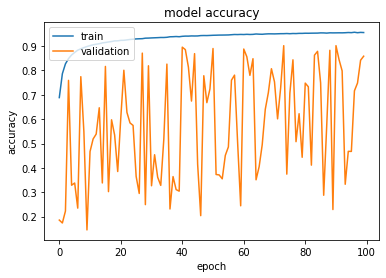

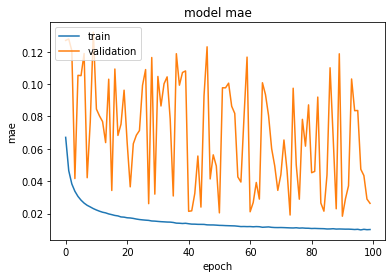

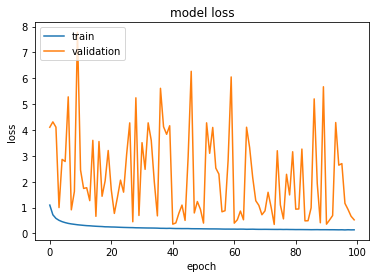

63/63 [==============================] - 2s 25ms/step - loss: 0.4936 - mae: 0.0254 - accuracy: 0.8649

Evaluation:
Loss, MAE, Accuracy [0.4935591220855713, 0.02535342611372471, 0.8648715019226074]
PSDS (0.11984024441944331, 'Valid file')

Filling post processing used.
PSDS (0.6609266539241164, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.7315242886543274, 0.9047466516494751, 0.42524805665016174, 0.9003149271011353, 0.4935591220855713]
Mean Loss 0.6910786092281341

MAE [0.035944677889347076, 0.040009915828704834, 0.022327791899442673, 0.042586326599121094, 0.02535342611372471]
Mean MAE 0.033244427666068076

Accuracy [0.8061140775680542, 0.7677249908447266, 0.8820078372955322, 0.755078136920929, 0.8648715019226074]
Mean Accuracy 0.8151593089103699

Model PSDS [0.06383967876584747, 0.09935546495913834, 0.09746690807811459, 0.16418473692249985, 0.11984024441944331]
Mean model PSDS 0.10893740662900872

Post processed PSDS [0.45965378737457535, nan, 0.7099699615152879, 0.5071703478616282, 0.6609266539241164]
Mean Post processed PSDS nan


In [4]:
# cross validation 5 fold
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 45s 78ms/step - loss: 1.5129 - mae: 0.0894 - accuracy: 0.5873 - val_loss: 1.9439 - val_mae: 0.1098 - val_accuracy: 0.4020

Epoch 00001: val_loss improved from inf to 1.94386, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 27s 63ms/step - loss: 0.8901 - mae: 0.0560 - accuracy: 0.7312 - val_loss: 5.7030 - val_mae: 0.1343 - val_accuracy: 0.1401

Epoch 00002: val_loss did not improve from 1.94386
Epoch 3/100
427/427 [==============================] - 26s 62ms/step - loss: 0.6959 - mae: 0.0454 - accuracy: 0.7903 - val_loss: 4.9807 - val_mae: 0.1332 - val_accuracy: 0.1359

Epoch 00003: val_loss did not improve from 1.94386
Epoch 4/100
427/427 [===


Epoch 00034: val_loss did not improve from 0.62035
Epoch 35/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2207 - mae: 0.0158 - accuracy: 0.9313 - val_loss: 0.6063 - val_mae: 0.0309 - val_accuracy: 0.8342

Epoch 00035: val_loss improved from 0.62035 to 0.60629, saving model to model.h5
Epoch 36/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2179 - mae: 0.0155 - accuracy: 0.9327 - val_loss: 4.8281 - val_mae: 0.1203 - val_accuracy: 0.2207

Epoch 00036: val_loss did not improve from 0.60629
Epoch 37/100
427/427 [==============================] - 25s 60ms/step - loss: 0.2157 - mae: 0.0155 - accuracy: 0.9326 - val_loss: 4.5095 - val_mae: 0.1131 - val_accuracy: 0.2652

Epoch 00037: val_loss did not improve from 0.60629
Epoch 38/100
427/427 [==============================] - 25s 59ms/step - loss: 0.2044 - mae: 0.0148 - accuracy: 0.9360 - val_loss: 1.9484 - val_mae: 0.0703 - val_accuracy: 0.5822

Epoch 00038: val_loss did not improve from 0.6062

427/427 [==============================] - 25s 60ms/step - loss: 0.1714 - mae: 0.0124 - accuracy: 0.9455 - val_loss: 7.3025 - val_mae: 0.1206 - val_accuracy: 0.2198

Epoch 00070: val_loss did not improve from 0.47082
Epoch 71/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1601 - mae: 0.0118 - accuracy: 0.9492 - val_loss: 1.0297 - val_mae: 0.0454 - val_accuracy: 0.7364

Epoch 00071: val_loss did not improve from 0.47082
Epoch 72/100
427/427 [==============================] - 25s 60ms/step - loss: 0.1538 - mae: 0.0114 - accuracy: 0.9515 - val_loss: 1.7677 - val_mae: 0.0634 - val_accuracy: 0.6064

Epoch 00072: val_loss did not improve from 0.47082
Epoch 73/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1568 - mae: 0.0114 - accuracy: 0.9507 - val_loss: 1.6594 - val_mae: 0.0651 - val_accuracy: 0.6064

Epoch 00073: val_loss did not improve from 0.47082
Epoch 74/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1574 - mae: 0

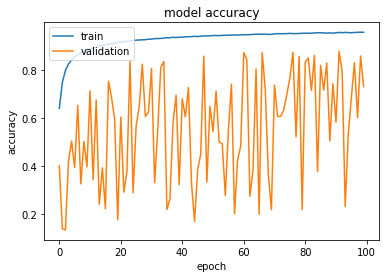

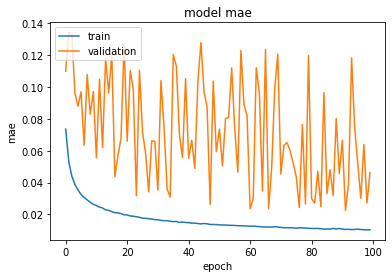

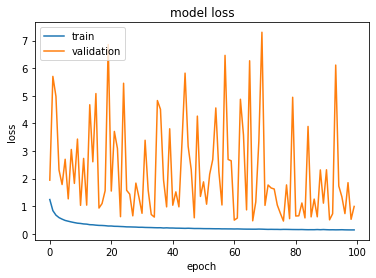

63/63 [==============================] - 2s 24ms/step - loss: 1.0217 - mae: 0.0478 - accuracy: 0.7203

Evaluation:
Loss, MAE, Accuracy [1.0216865539550781, 0.04782867059111595, 0.7202890515327454]
PSDS (0.09594540398599179, 'Valid file')

Filling post processing used.
PSDS (0.5516651675421026, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 42s 70ms/step - loss: 1.5176 - mae: 0.0912 - accuracy: 0.5996 - val_loss: 1.6849 - val_mae: 0.0902 - val_accuracy: 0.4903

Epoch 00001: val_loss improved from inf to 1.68489, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 61ms/step - loss: 0.8216 - mae: 0.0518 - accuracy: 0.7596 - val_loss: 2.0407 - val_mae: 0.1028 - val_accuracy: 0.4136

Epoch 00002: val_loss did not improve from 1.68489
Epoch 3/100
427/427 [==============================] - 26s 60ms/step - loss: 0.6785 - mae: 0.0444 - accuracy: 0.7962 - val_loss: 1.4210 - val_mae: 0.0605 - val_accuracy: 0.6391

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.55019
Epoch 35/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2164 - mae: 0.0155 - accuracy: 0.9328 - val_loss: 1.6862 - val_mae: 0.0691 - val_accuracy: 0.5839

Epoch 00035: val_loss did not improve from 0.55019
Epoch 36/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2135 - mae: 0.0153 - accuracy: 0.9344 - val_loss: 1.2042 - val_mae: 0.0552 - val_accuracy: 0.6781

Epoch 00036: val_loss did not improve from 0.55019
Epoch 37/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2143 - mae: 0.0153 - accuracy: 0.9338 - val_loss: 1.1081 - val_mae: 0.0552 - val_accuracy: 0.6837

Epoch 00037: val_loss did not improve from 0.55019
Epoch 38/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2123 - mae: 0.0152 - accuracy: 0.9336 - val_loss: 4.3823 - val_mae: 0.1113 - val_accuracy: 0.2832

Epoch 00038: val_loss did not improve from 0.55019
Epoch 39/100
427/427 [======

427/427 [==============================] - 26s 60ms/step - loss: 0.1648 - mae: 0.0120 - accuracy: 0.9479 - val_loss: 4.3744 - val_mae: 0.1006 - val_accuracy: 0.3567

Epoch 00070: val_loss did not improve from 0.55019
Epoch 71/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1654 - mae: 0.0120 - accuracy: 0.9479 - val_loss: 1.3877 - val_mae: 0.0590 - val_accuracy: 0.6495

Epoch 00071: val_loss did not improve from 0.55019
Epoch 72/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1593 - mae: 0.0118 - accuracy: 0.9492 - val_loss: 3.2025 - val_mae: 0.1011 - val_accuracy: 0.3504

Epoch 00072: val_loss did not improve from 0.55019
Epoch 73/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1577 - mae: 0.0116 - accuracy: 0.9497 - val_loss: 1.2428 - val_mae: 0.0525 - val_accuracy: 0.6941

Epoch 00073: val_loss did not improve from 0.55019
Epoch 74/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1570 - mae: 0

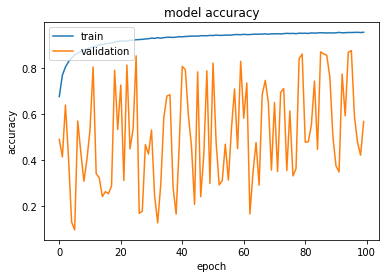

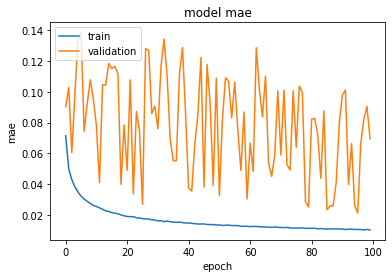

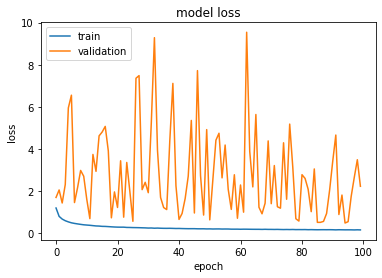

63/63 [==============================] - 2s 24ms/step - loss: 2.1623 - mae: 0.0697 - accuracy: 0.5665

Evaluation:
Loss, MAE, Accuracy [2.162334680557251, 0.0697191134095192, 0.5665203332901001]
PSDS (0.07695642586123076, 'Valid file')

Filling post processing used.
PSDS (0.3539525128217223, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 42s 71ms/step - loss: 1.5464 - mae: 0.0927 - accuracy: 0.5956 - val_loss: 2.9701 - val_mae: 0.1294 - val_accuracy: 0.1891

Epoch 00001: val_loss improved from inf to 2.97011, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 61ms/step - loss: 0.8349 - mae: 0.0522 - accuracy: 0.7542 - val_loss: 4.9422 - val_mae: 0.1358 - val_accuracy: 0.1188

Epoch 00002: val_loss did not improve from 2.97011
Epoch 3/100
427/427 [==============================] - 26s 61ms/step - loss: 0.6790 - mae: 0.0440 - accuracy: 0.7974 - val_loss: 1.8943 - val_mae: 0.0913 - val_accuracy: 0.4585

Epoch 00003: 

427/427 [==============================] - 26s 60ms/step - loss: 0.2161 - mae: 0.0155 - accuracy: 0.9329 - val_loss: 2.1014 - val_mae: 0.0810 - val_accuracy: 0.5084

Epoch 00034: val_loss did not improve from 0.64833
Epoch 35/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2188 - mae: 0.0156 - accuracy: 0.9324 - val_loss: 2.5158 - val_mae: 0.0867 - val_accuracy: 0.4582

Epoch 00035: val_loss did not improve from 0.64833
Epoch 36/100
427/427 [==============================] - 26s 61ms/step - loss: 0.2138 - mae: 0.0152 - accuracy: 0.9343 - val_loss: 5.3234 - val_mae: 0.1232 - val_accuracy: 0.2027

Epoch 00036: val_loss did not improve from 0.64833
Epoch 37/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2129 - mae: 0.0153 - accuracy: 0.9336 - val_loss: 7.8219 - val_mae: 0.1321 - val_accuracy: 0.1420

Epoch 00037: val_loss did not improve from 0.64833
Epoch 38/100
427/427 [==============================] - 26s 61ms/step - loss: 0.2149 - mae: 0


Epoch 00069: val_loss did not improve from 0.54112
Epoch 70/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1656 - mae: 0.0120 - accuracy: 0.9479 - val_loss: 1.2364 - val_mae: 0.0525 - val_accuracy: 0.6945

Epoch 00070: val_loss did not improve from 0.54112
Epoch 71/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1667 - mae: 0.0120 - accuracy: 0.9480 - val_loss: 4.5749 - val_mae: 0.1053 - val_accuracy: 0.3206

Epoch 00071: val_loss did not improve from 0.54112
Epoch 72/100
427/427 [==============================] - 26s 61ms/step - loss: 0.1586 - mae: 0.0117 - accuracy: 0.9498 - val_loss: 0.7166 - val_mae: 0.0393 - val_accuracy: 0.7826

Epoch 00072: val_loss did not improve from 0.54112
Epoch 73/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1591 - mae: 0.0115 - accuracy: 0.9499 - val_loss: 1.4540 - val_mae: 0.0643 - val_accuracy: 0.6131

Epoch 00073: val_loss did not improve from 0.54112
Epoch 74/100
427/427 [======

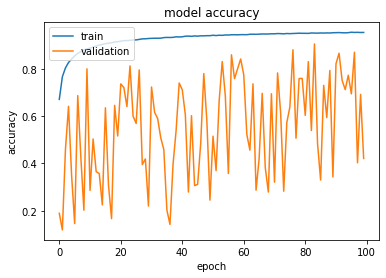

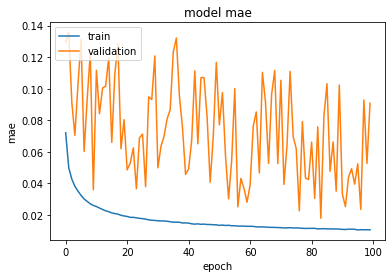

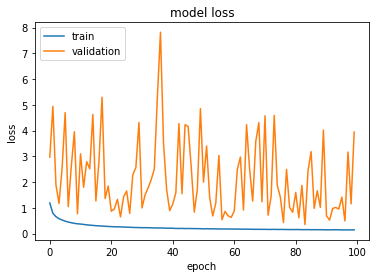

63/63 [==============================] - 2s 24ms/step - loss: 4.0446 - mae: 0.0923 - accuracy: 0.4114

Evaluation:
Loss, MAE, Accuracy [4.0446295738220215, 0.09226659685373306, 0.4114375114440918]
PSDS (0.013610339409260961, 'Valid file')

Filling post processing used.
PSDS (0.28452920366631895, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
427/427 [==============================] - 43s 79ms/step - loss: 1.4846 - mae: 0.0890 - accuracy: 0.5971 - val_loss: 2.8812 - val_mae: 0.1263 - val_accuracy: 0.2232

Epoch 00001: val_loss improved from inf to 2.88118, saving model to model.h5
Epoch 2/100
427/427 [==============================] - 26s 62ms/step - loss: 0.8266 - mae: 0.0525 - accuracy: 0.7522 - val_loss: 2.1335 - val_mae: 0.1084 - val_accuracy: 0.3519

Epoch 00002: val_loss improved from 2.88118 to 2.13347, saving model to model.h5
Epoch 3/100
427/427 [==============================] - 26s 62ms/step - loss: 0.6887 - mae: 0.0451 - accuracy: 0.7909 - val_loss: 2.1324 - val_mae: 0.0968 - val_a

427/427 [==============================] - 26s 61ms/step - loss: 0.2119 - mae: 0.0152 - accuracy: 0.9341 - val_loss: 1.0020 - val_mae: 0.0458 - val_accuracy: 0.7419

Epoch 00034: val_loss did not improve from 0.57190
Epoch 35/100
427/427 [==============================] - 26s 61ms/step - loss: 0.2160 - mae: 0.0155 - accuracy: 0.9325 - val_loss: 2.8644 - val_mae: 0.0987 - val_accuracy: 0.3685

Epoch 00035: val_loss did not improve from 0.57190
Epoch 36/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2104 - mae: 0.0151 - accuracy: 0.9343 - val_loss: 4.0317 - val_mae: 0.1066 - val_accuracy: 0.3163

Epoch 00036: val_loss did not improve from 0.57190
Epoch 37/100
427/427 [==============================] - 26s 61ms/step - loss: 0.2116 - mae: 0.0151 - accuracy: 0.9340 - val_loss: 2.1553 - val_mae: 0.0878 - val_accuracy: 0.4593

Epoch 00037: val_loss did not improve from 0.57190
Epoch 38/100
427/427 [==============================] - 26s 60ms/step - loss: 0.2109 - mae: 0


Epoch 00069: val_loss did not improve from 0.52542
Epoch 70/100
427/427 [==============================] - 26s 60ms/step - loss: 0.1591 - mae: 0.0117 - accuracy: 0.9489 - val_loss: 1.6001 - val_mae: 0.0653 - val_accuracy: 0.6023

Epoch 00070: val_loss did not improve from 0.52542
Epoch 71/100
427/427 [==============================] - 25s 60ms/step - loss: 0.1611 - mae: 0.0117 - accuracy: 0.9493 - val_loss: 1.7845 - val_mae: 0.0659 - val_accuracy: 0.5955

Epoch 00071: val_loss did not improve from 0.52542
Epoch 72/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1592 - mae: 0.0117 - accuracy: 0.9495 - val_loss: 1.0081 - val_mae: 0.0444 - val_accuracy: 0.7390

Epoch 00072: val_loss did not improve from 0.52542
Epoch 73/100
427/427 [==============================] - 25s 59ms/step - loss: 0.1559 - mae: 0.0114 - accuracy: 0.9506 - val_loss: 1.1180 - val_mae: 0.0422 - val_accuracy: 0.7530

Epoch 00073: val_loss did not improve from 0.52542
Epoch 74/100
427/427 [======

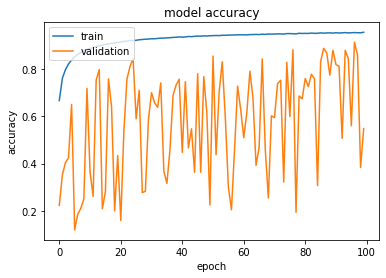

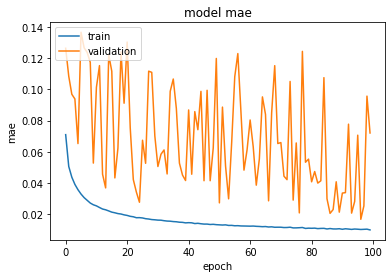

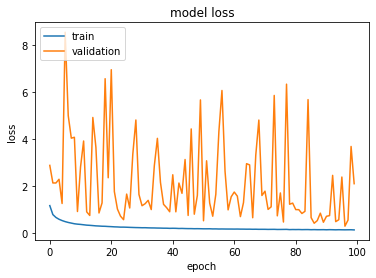

63/63 [==============================] - 2s 25ms/step - loss: 2.1163 - mae: 0.0725 - accuracy: 0.5457

Evaluation:
Loss, MAE, Accuracy [2.1162967681884766, 0.07248115539550781, 0.545703113079071]
PSDS (0.05075232871033103, 'Valid file')

Filling post processing used.
PSDS (0.28061432548945603, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 54s 67ms/step - loss: 1.4210 - mae: 0.0855 - accuracy: 0.6233 - val_loss: 2.1950 - val_mae: 0.1013 - val_accuracy: 0.3592

Epoch 00001: val_loss improved from inf to 2.19499, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 32s 61ms/step - loss: 0.7578 - mae: 0.0485 - accuracy: 0.7753 - val_loss: 2.7538 - val_mae: 0.1082 - val_accuracy: 0.3213

Epoch 00002: val_loss did not improve from 2.19499
Epoch 3/100
534/534 [==============================] - 32s 60ms/step - loss: 0.6177 - mae: 0.0405 - accuracy: 0.8143 - val_loss: 3.7634 - val_mae: 0.1255 - val_accuracy: 0.1844

Epoch 00003: val_


Epoch 00034: val_loss did not improve from 0.50694
Epoch 35/100
534/534 [==============================] - 32s 61ms/step - loss: 0.2046 - mae: 0.0146 - accuracy: 0.9366 - val_loss: 2.3318 - val_mae: 0.0807 - val_accuracy: 0.4902

Epoch 00035: val_loss did not improve from 0.50694
Epoch 36/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2061 - mae: 0.0148 - accuracy: 0.9353 - val_loss: 1.5094 - val_mae: 0.0704 - val_accuracy: 0.5943

Epoch 00036: val_loss did not improve from 0.50694
Epoch 37/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1989 - mae: 0.0143 - accuracy: 0.9380 - val_loss: 0.5357 - val_mae: 0.0298 - val_accuracy: 0.8485

Epoch 00037: val_loss did not improve from 0.50694
Epoch 38/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1943 - mae: 0.0140 - accuracy: 0.9392 - val_loss: 1.9065 - val_mae: 0.0791 - val_accuracy: 0.4958

Epoch 00038: val_loss did not improve from 0.50694
Epoch 39/100
534/534 [======

534/534 [==============================] - 32s 61ms/step - loss: 0.1518 - mae: 0.0110 - accuracy: 0.9523 - val_loss: 1.1049 - val_mae: 0.0517 - val_accuracy: 0.7000

Epoch 00070: val_loss did not improve from 0.47680
Epoch 71/100
534/534 [==============================] - 32s 61ms/step - loss: 0.1544 - mae: 0.0113 - accuracy: 0.9507 - val_loss: 3.8982 - val_mae: 0.1062 - val_accuracy: 0.3127

Epoch 00071: val_loss did not improve from 0.47680
Epoch 72/100
534/534 [==============================] - 32s 61ms/step - loss: 0.1530 - mae: 0.0112 - accuracy: 0.9515 - val_loss: 3.5521 - val_mae: 0.0993 - val_accuracy: 0.3629

Epoch 00072: val_loss did not improve from 0.47680
Epoch 73/100
534/534 [==============================] - 33s 61ms/step - loss: 0.1530 - mae: 0.0112 - accuracy: 0.9517 - val_loss: 0.7737 - val_mae: 0.0316 - val_accuracy: 0.8154

Epoch 00073: val_loss did not improve from 0.47680
Epoch 74/100
534/534 [==============================] - 33s 61ms/step - loss: 0.1502 - mae: 0

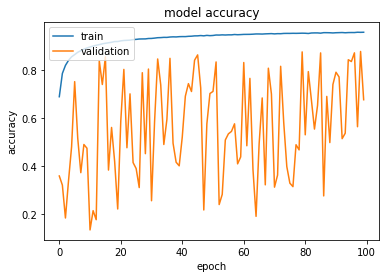

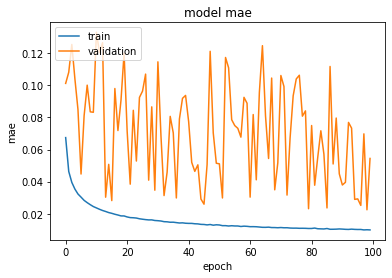

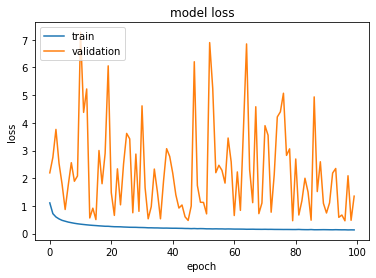

63/63 [==============================] - 1s 23ms/step - loss: 1.3532 - mae: 0.0545 - accuracy: 0.6763

Evaluation:
Loss, MAE, Accuracy [1.3532155752182007, 0.05445510149002075, 0.6763272285461426]
PSDS (0.033891732812479786, 'Valid file')

Filling post processing used.
PSDS (0.31484301806850495, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [1.0216865539550781, 2.162334680557251, 4.0446295738220215, 2.1162967681884766, 1.3532155752182007]
Mean Loss 2.1396326303482054

MAE [0.04782867059111595, 0.0697191134095192, 0.09226659685373306, 0.07248115539550781, 0.05445510149002075]
Mean MAE 0.06735012754797935

Accuracy [0.7202890515327454, 0.5665203332901001, 0.4114375114440918, 0.545703113079071, 0.6763272285461426]
Mean Accuracy 0.5840554475784302

Model PSDS [0.09594540398599179, 0.07695642586123076, 0.013610339409260961, 0.05075232871033103, 0.033891732812479786]
Mean model PSDS 0.05423124615585886

Post processed PSDS [0.5516651675421026, 0.3539525128217223, 0.28452920366631895, 0.28061432548945603, 0.31484301806850495]
Mean Post processed PSDS 0.35712084551762097


In [6]:
# cross validation  5 fold mit val test split 0.2
unet_param['val_split_fraction'] = 0.2
test_index_list = [(0, 2000), (2000, 4000), (4000, 6000), (6000, 8000), (8000,  -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 1000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 1000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 52s 67ms/step - loss: 1.4901 - mae: 0.0901 - accuracy: 0.5872 - val_loss: 1.4216 - val_mae: 0.0955 - val_accuracy: 0.5662

Epoch 00001: val_loss improved from inf to 1.42157, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 28s 58ms/step - loss: 0.7832 - mae: 0.0500 - accuracy: 0.7692 - val_loss: 1.1165 - val_mae: 0.0683 - val_accuracy: 0.6545

Epoch 00002: val_loss improved from 1.42157 to 1.11650, saving model to model.h5
Epoch 3/100
480/480 [==============================] - 28s 58ms/step - loss: 0.6476 - mae: 0.0425 - accuracy: 0.8051 - val_loss: 2.2457 - val_mae: 0.1011 - val_accuracy: 0.3927

Epoch 00003: val_loss did not improve from 1.

480/480 [==============================] - 27s 56ms/step - loss: 0.1996 - mae: 0.0143 - accuracy: 0.9379 - val_loss: 6.3999 - val_mae: 0.1226 - val_accuracy: 0.2038

Epoch 00035: val_loss did not improve from 0.55015
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2038 - mae: 0.0146 - accuracy: 0.9368 - val_loss: 2.0190 - val_mae: 0.0725 - val_accuracy: 0.5531

Epoch 00036: val_loss did not improve from 0.55015
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1990 - mae: 0.0142 - accuracy: 0.9386 - val_loss: 1.6652 - val_mae: 0.0684 - val_accuracy: 0.5787

Epoch 00037: val_loss did not improve from 0.55015
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1966 - mae: 0.0140 - accuracy: 0.9391 - val_loss: 8.1120 - val_mae: 0.1289 - val_accuracy: 0.1620

Epoch 00038: val_loss did not improve from 0.55015
Epoch 39/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1977 - mae: 0


Epoch 00070: val_loss did not improve from 0.46651
Epoch 71/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1485 - mae: 0.0109 - accuracy: 0.9532 - val_loss: 4.0012 - val_mae: 0.1030 - val_accuracy: 0.3389

Epoch 00071: val_loss did not improve from 0.46651
Epoch 72/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1542 - mae: 0.0112 - accuracy: 0.9512 - val_loss: 0.7928 - val_mae: 0.0379 - val_accuracy: 0.7909

Epoch 00072: val_loss did not improve from 0.46651
Epoch 73/100
480/480 [==============================] - 27s 57ms/step - loss: 0.1451 - mae: 0.0107 - accuracy: 0.9539 - val_loss: 0.4273 - val_mae: 0.0216 - val_accuracy: 0.8840

Epoch 00073: val_loss improved from 0.46651 to 0.42731, saving model to model.h5
Epoch 74/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1467 - mae: 0.0108 - accuracy: 0.9534 - val_loss: 3.5457 - val_mae: 0.0992 - val_accuracy: 0.3580

Epoch 00074: val_loss did not improve from 0.4273

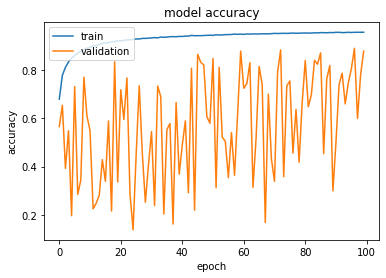

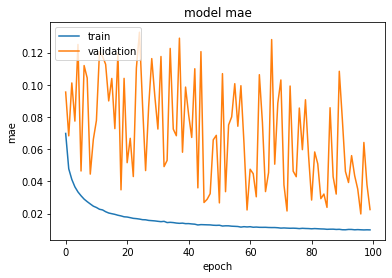

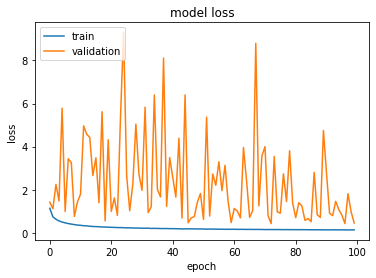

32/32 [==============================] - 1s 24ms/step - loss: 0.4704 - mae: 0.0229 - accuracy: 0.8767

Evaluation:
Loss, MAE, Accuracy [0.470390647649765, 0.022938961163163185, 0.8766531348228455]
PSDS (0.1382104293622132, 'Valid file')

Filling post processing used.
PSDS (0.6772301467205938, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (1000, 2000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 1000 to 2000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 48s 72ms/step - loss: 1.4690 - mae: 0.0881 - accuracy: 0.6007 - val_loss: 2.1433 - val_mae: 0.1089 - val_accuracy: 0.3587

Epoch 00001: val_loss improved from inf to 2.14335, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 60ms/step - loss: 0.8142 - mae: 0.0517 - accuracy: 0.7581 - val_loss: 3.6952 - val_mae: 0.1279 - val_accuracy: 0.1979

Epoch 00002: val_loss did not improve from 2.14335
Epoch 3/100
480/480 [==============================] - 28s 59ms/step - loss: 0.6721 - mae: 0.0437 - accuracy: 0.7984 - val_loss: 7.1028 - val_mae: 0.1424 - val_accuracy: 0.0746

Epoch 00003: 

480/480 [==============================] - 26s 55ms/step - loss: 0.2050 - mae: 0.0146 - accuracy: 0.9365 - val_loss: 3.5342 - val_mae: 0.1034 - val_accuracy: 0.3370

Epoch 00035: val_loss did not improve from 1.15256
Epoch 36/100
480/480 [==============================] - 35s 73ms/step - loss: 0.2063 - mae: 0.0146 - accuracy: 0.9363 - val_loss: 1.2445 - val_mae: 0.0587 - val_accuracy: 0.6695

Epoch 00036: val_loss did not improve from 1.15256
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2026 - mae: 0.0145 - accuracy: 0.9371 - val_loss: 0.6530 - val_mae: 0.0294 - val_accuracy: 0.8344

Epoch 00037: val_loss improved from 1.15256 to 0.65296, saving model to model.h5
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1974 - mae: 0.0141 - accuracy: 0.9390 - val_loss: 1.9650 - val_mae: 0.0811 - val_accuracy: 0.4986

Epoch 00038: val_loss did not improve from 0.65296
Epoch 39/100
480/480 [==============================] - 29s 61m

480/480 [==============================] - 25s 52ms/step - loss: 0.1552 - mae: 0.0113 - accuracy: 0.9511 - val_loss: 0.4998 - val_mae: 0.0238 - val_accuracy: 0.8713

Epoch 00070: val_loss improved from 0.51420 to 0.49984, saving model to model.h5
Epoch 71/100
480/480 [==============================] - 25s 53ms/step - loss: 0.1534 - mae: 0.0112 - accuracy: 0.9514 - val_loss: 4.5413 - val_mae: 0.1069 - val_accuracy: 0.3101

Epoch 00071: val_loss did not improve from 0.49984
Epoch 72/100
480/480 [==============================] - 25s 52ms/step - loss: 0.1519 - mae: 0.0110 - accuracy: 0.9527 - val_loss: 5.6124 - val_mae: 0.1108 - val_accuracy: 0.2837

Epoch 00072: val_loss did not improve from 0.49984
Epoch 73/100
480/480 [==============================] - 25s 52ms/step - loss: 0.1468 - mae: 0.0108 - accuracy: 0.9532 - val_loss: 0.5214 - val_mae: 0.0267 - val_accuracy: 0.8606

Epoch 00073: val_loss did not improve from 0.49984
Epoch 74/100
480/480 [==============================] - 27s 55m

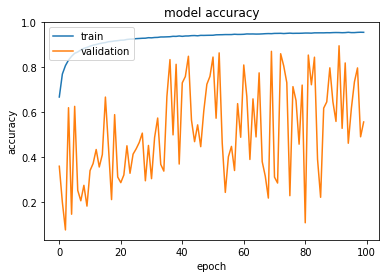

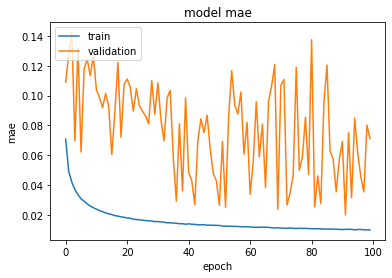

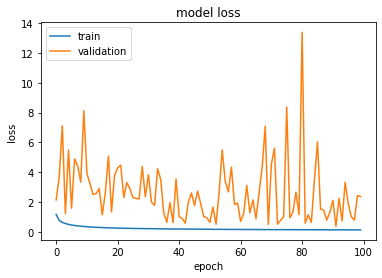

32/32 [==============================] - 1s 22ms/step - loss: 2.4636 - mae: 0.0728 - accuracy: 0.5440

Evaluation:
Loss, MAE, Accuracy [2.4635894298553467, 0.07275959849357605, 0.5439687371253967]
PSDS (0.062206050219440465, 'Valid file')

Filling post processing used.
PSDS (0.3106380035153818, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 3000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 3000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 44s 66ms/step - loss: 1.5388 - mae: 0.0904 - accuracy: 0.5732 - val_loss: 1.2638 - val_mae: 0.0652 - val_accuracy: 0.6441

Epoch 00001: val_loss improved from inf to 1.26382, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.8596 - mae: 0.0541 - accuracy: 0.7445 - val_loss: 4.5394 - val_mae: 0.1289 - val_accuracy: 0.1756

Epoch 00002: val_loss did not improve from 1.26382
Epoch 3/100
480/480 [==============================] - 26s 53ms/step - loss: 0.6810 - mae: 0.0445 - accuracy: 0.7935 - val_loss: 4.9385 - val_mae: 0.1213 - val_accuracy: 0.2305

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.50341
Epoch 35/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2109 - mae: 0.0152 - accuracy: 0.9341 - val_loss: 1.4449 - val_mae: 0.0671 - val_accuracy: 0.6024

Epoch 00035: val_loss did not improve from 0.50341
Epoch 36/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2086 - mae: 0.0149 - accuracy: 0.9349 - val_loss: 1.4681 - val_mae: 0.0628 - val_accuracy: 0.6311

Epoch 00036: val_loss did not improve from 0.50341
Epoch 37/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2073 - mae: 0.0150 - accuracy: 0.9347 - val_loss: 0.7022 - val_mae: 0.0376 - val_accuracy: 0.7978

Epoch 00037: val_loss did not improve from 0.50341
Epoch 38/100
480/480 [==============================] - 25s 53ms/step - loss: 0.2031 - mae: 0.0146 - accuracy: 0.9367 - val_loss: 0.9233 - val_mae: 0.0498 - val_accuracy: 0.7207

Epoch 00038: val_loss did not improve from 0.50341
Epoch 39/100
480/480 [======

480/480 [==============================] - 26s 53ms/step - loss: 0.1603 - mae: 0.0117 - accuracy: 0.9491 - val_loss: 0.9354 - val_mae: 0.0430 - val_accuracy: 0.7632

Epoch 00070: val_loss did not improve from 0.43754
Epoch 71/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1566 - mae: 0.0115 - accuracy: 0.9500 - val_loss: 1.1046 - val_mae: 0.0479 - val_accuracy: 0.7200

Epoch 00071: val_loss did not improve from 0.43754
Epoch 72/100
480/480 [==============================] - 25s 52ms/step - loss: 0.1548 - mae: 0.0113 - accuracy: 0.9514 - val_loss: 0.4147 - val_mae: 0.0237 - val_accuracy: 0.8817

Epoch 00072: val_loss improved from 0.43754 to 0.41468, saving model to model.h5
Epoch 73/100
480/480 [==============================] - 25s 53ms/step - loss: 0.1518 - mae: 0.0111 - accuracy: 0.9518 - val_loss: 0.7635 - val_mae: 0.0399 - val_accuracy: 0.7808

Epoch 00073: val_loss did not improve from 0.41468
Epoch 74/100
480/480 [==============================] - 25s 52m

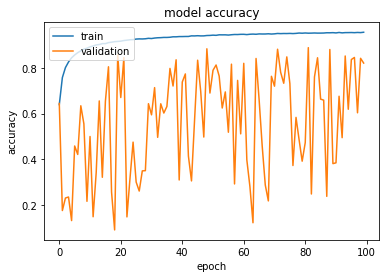

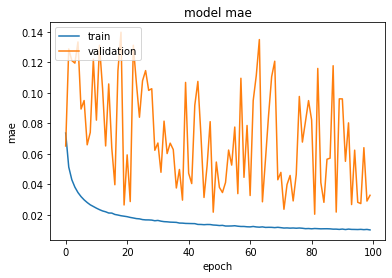

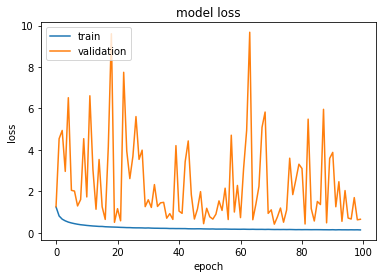

32/32 [==============================] - 1s 22ms/step - loss: 0.6317 - mae: 0.0323 - accuracy: 0.8247

Evaluation:
Loss, MAE, Accuracy [0.6317099332809448, 0.032331548631191254, 0.8246687650680542]
PSDS (0.029155510240533467, 'Valid file')

Filling post processing used.
PSDS (0.5989025601564202, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (3000, 4000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 3000 to 4000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 50s 64ms/step - loss: 1.4915 - mae: 0.0893 - accuracy: 0.5935 - val_loss: 2.2329 - val_mae: 0.1186 - val_accuracy: 0.3263

Epoch 00001: val_loss improved from inf to 2.23287, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 26s 53ms/step - loss: 0.8201 - mae: 0.0521 - accuracy: 0.7595 - val_loss: 2.7166 - val_mae: 0.1112 - val_accuracy: 0.2939

Epoch 00002: val_loss did not improve from 2.23287
Epoch 3/100
480/480 [==============================] - 25s 52ms/step - loss: 0.6472 - mae: 0.0426 - accuracy: 0.8067 - val_loss: 3.6519 - val_mae: 0.1132 - val_accuracy: 0.2824

Epoch 00003: 

480/480 [==============================] - 26s 54ms/step - loss: 0.2122 - mae: 0.0152 - accuracy: 0.9334 - val_loss: 3.4040 - val_mae: 0.1021 - val_accuracy: 0.3443

Epoch 00034: val_loss did not improve from 0.54302
Epoch 35/100
480/480 [==============================] - 25s 52ms/step - loss: 0.2126 - mae: 0.0151 - accuracy: 0.9338 - val_loss: 1.0694 - val_mae: 0.0507 - val_accuracy: 0.7061

Epoch 00035: val_loss did not improve from 0.54302
Epoch 36/100
480/480 [==============================] - 25s 53ms/step - loss: 0.2098 - mae: 0.0150 - accuracy: 0.9347 - val_loss: 1.1646 - val_mae: 0.0542 - val_accuracy: 0.6835

Epoch 00036: val_loss did not improve from 0.54302
Epoch 37/100
480/480 [==============================] - 26s 53ms/step - loss: 0.2045 - mae: 0.0147 - accuracy: 0.9362 - val_loss: 2.4883 - val_mae: 0.0785 - val_accuracy: 0.5159

Epoch 00037: val_loss did not improve from 0.54302
Epoch 38/100
480/480 [==============================] - 25s 52ms/step - loss: 0.1995 - mae: 0


Epoch 00069: val_loss did not improve from 0.36363
Epoch 70/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1552 - mae: 0.0113 - accuracy: 0.9511 - val_loss: 4.8958 - val_mae: 0.1039 - val_accuracy: 0.3299

Epoch 00070: val_loss did not improve from 0.36363
Epoch 71/100
480/480 [==============================] - 29s 60ms/step - loss: 0.1584 - mae: 0.0115 - accuracy: 0.9500 - val_loss: 2.0002 - val_mae: 0.0722 - val_accuracy: 0.5446

Epoch 00071: val_loss did not improve from 0.36363
Epoch 72/100
480/480 [==============================] - 30s 62ms/step - loss: 0.1618 - mae: 0.0118 - accuracy: 0.9488 - val_loss: 2.7100 - val_mae: 0.0823 - val_accuracy: 0.4795

Epoch 00072: val_loss did not improve from 0.36363
Epoch 73/100
480/480 [==============================] - 27s 57ms/step - loss: 0.1521 - mae: 0.0111 - accuracy: 0.9517 - val_loss: 0.5163 - val_mae: 0.0255 - val_accuracy: 0.8618

Epoch 00073: val_loss did not improve from 0.36363
Epoch 74/100
480/480 [======

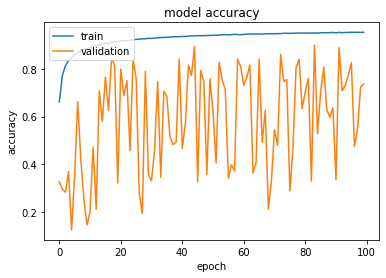

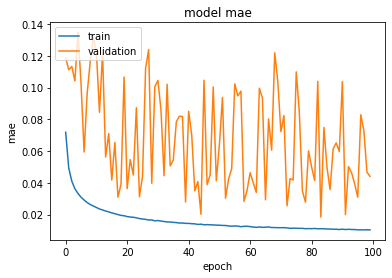

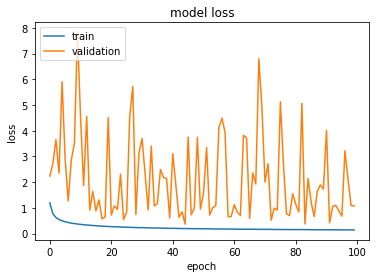

32/32 [==============================] - 1s 25ms/step - loss: 1.0263 - mae: 0.0424 - accuracy: 0.7488

Evaluation:
Loss, MAE, Accuracy [1.0263255834579468, 0.04243346303701401, 0.748828113079071]
PSDS (0.06403869193581947, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 2 file(s) missing, e.g. ['03389_mix.wav', '03470_mix.wav']")


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 5000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 5000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 53s 71ms/step - loss: 1.4951 - mae: 0.0899 - accuracy: 0.5905 - val_loss: 1.7105 - val_mae: 0.0960 - val_accuracy: 0.4869

Epoch 00001: val_loss improved from inf to 1.71053, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 61ms/step - loss: 0.8188 - mae: 0.0522 - accuracy: 0.7563 - val_loss: 4.3058 - val_mae: 0.1321 - val_accuracy: 0.1389

Epoch 00002: val_loss did not improve from 1.71053
Epoch 3/100
480/480 [==============================] - 29s 60ms/step - loss: 0.6710 - mae: 0.0436 - accuracy: 0.7996 - val_loss: 3.5823 - val_mae: 0.1164 - val_accuracy: 0.2614

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.80380
Epoch 35/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2112 - mae: 0.0150 - accuracy: 0.9347 - val_loss: 0.6463 - val_mae: 0.0372 - val_accuracy: 0.8086

Epoch 00035: val_loss improved from 0.80380 to 0.64635, saving model to model.h5
Epoch 36/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2124 - mae: 0.0151 - accuracy: 0.9346 - val_loss: 5.5862 - val_mae: 0.1193 - val_accuracy: 0.2298

Epoch 00036: val_loss did not improve from 0.64635
Epoch 37/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2133 - mae: 0.0152 - accuracy: 0.9338 - val_loss: 1.2275 - val_mae: 0.0514 - val_accuracy: 0.6973

Epoch 00037: val_loss did not improve from 0.64635
Epoch 38/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2060 - mae: 0.0148 - accuracy: 0.9362 - val_loss: 3.2338 - val_mae: 0.0950 - val_accuracy: 0.3973

Epoch 00038: val_loss did not improve from 0.6463

480/480 [==============================] - 30s 62ms/step - loss: 0.1640 - mae: 0.0118 - accuracy: 0.9485 - val_loss: 1.5619 - val_mae: 0.0641 - val_accuracy: 0.6202

Epoch 00070: val_loss did not improve from 0.41597
Epoch 71/100
480/480 [==============================] - 29s 61ms/step - loss: 0.1631 - mae: 0.0119 - accuracy: 0.9482 - val_loss: 4.0430 - val_mae: 0.1010 - val_accuracy: 0.3563

Epoch 00071: val_loss did not improve from 0.41597
Epoch 72/100
480/480 [==============================] - 30s 62ms/step - loss: 0.1609 - mae: 0.0117 - accuracy: 0.9494 - val_loss: 1.6486 - val_mae: 0.0638 - val_accuracy: 0.6127

Epoch 00072: val_loss did not improve from 0.41597
Epoch 73/100
480/480 [==============================] - 30s 62ms/step - loss: 0.1601 - mae: 0.0116 - accuracy: 0.9495 - val_loss: 0.5673 - val_mae: 0.0286 - val_accuracy: 0.8405

Epoch 00073: val_loss did not improve from 0.41597
Epoch 74/100
480/480 [==============================] - 30s 62ms/step - loss: 0.1581 - mae: 0

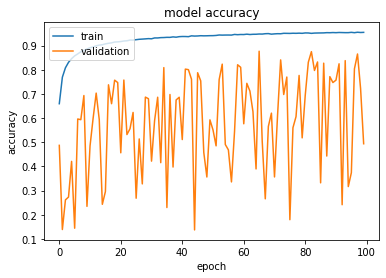

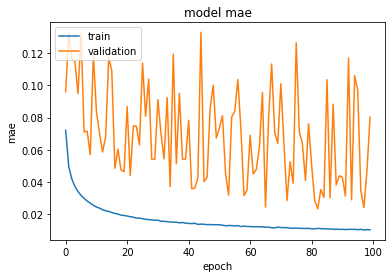

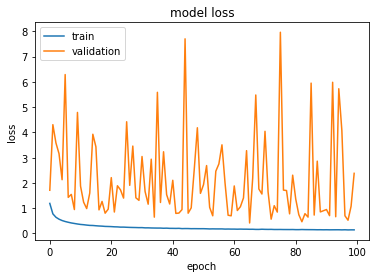

32/32 [==============================] - 1s 26ms/step - loss: 2.4542 - mae: 0.0815 - accuracy: 0.4853

Evaluation:
Loss, MAE, Accuracy [2.454240322113037, 0.08148180693387985, 0.4853406250476837]
PSDS (0.05846081408882844, 'Valid file')

Filling post processing used.
PSDS (0.25722469808843157, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (5000, 6000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 5000 to 6000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 52s 69ms/step - loss: 1.5086 - mae: 0.0905 - accuracy: 0.5960 - val_loss: 1.9517 - val_mae: 0.1027 - val_accuracy: 0.4291

Epoch 00001: val_loss improved from inf to 1.95170, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 61ms/step - loss: 0.7907 - mae: 0.0507 - accuracy: 0.7623 - val_loss: 4.1822 - val_mae: 0.1289 - val_accuracy: 0.1692

Epoch 00002: val_loss did not improve from 1.95170
Epoch 3/100
480/480 [==============================] - 29s 61ms/step - loss: 0.6434 - mae: 0.0423 - accuracy: 0.8056 - val_loss: 6.8396 - val_mae: 0.1335 - val_accuracy: 0.1390

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.64931
Epoch 35/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2058 - mae: 0.0148 - accuracy: 0.9357 - val_loss: 0.9161 - val_mae: 0.0503 - val_accuracy: 0.7260

Epoch 00035: val_loss did not improve from 0.64931
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2099 - mae: 0.0150 - accuracy: 0.9349 - val_loss: 0.8082 - val_mae: 0.0380 - val_accuracy: 0.7817

Epoch 00036: val_loss did not improve from 0.64931
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2115 - mae: 0.0150 - accuracy: 0.9346 - val_loss: 1.3752 - val_mae: 0.0563 - val_accuracy: 0.6662

Epoch 00037: val_loss did not improve from 0.64931
Epoch 38/100
480/480 [==============================] - 28s 58ms/step - loss: 0.2046 - mae: 0.0147 - accuracy: 0.9358 - val_loss: 1.0034 - val_mae: 0.0543 - val_accuracy: 0.6947

Epoch 00038: val_loss did not improve from 0.64931
Epoch 39/100
480/480 [======

480/480 [==============================] - 27s 56ms/step - loss: 0.1605 - mae: 0.0116 - accuracy: 0.9494 - val_loss: 3.0265 - val_mae: 0.0952 - val_accuracy: 0.3968

Epoch 00070: val_loss did not improve from 0.52256
Epoch 71/100
480/480 [==============================] - 27s 55ms/step - loss: 0.1583 - mae: 0.0117 - accuracy: 0.9496 - val_loss: 5.8479 - val_mae: 0.1096 - val_accuracy: 0.2915

Epoch 00071: val_loss did not improve from 0.52256
Epoch 72/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1592 - mae: 0.0116 - accuracy: 0.9496 - val_loss: 0.5027 - val_mae: 0.0250 - val_accuracy: 0.8665

Epoch 00072: val_loss improved from 0.52256 to 0.50271, saving model to model.h5
Epoch 73/100
480/480 [==============================] - 28s 57ms/step - loss: 0.1555 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 0.8527 - val_mae: 0.0378 - val_accuracy: 0.7871

Epoch 00073: val_loss did not improve from 0.50271
Epoch 74/100
480/480 [==============================] - 27s 56m

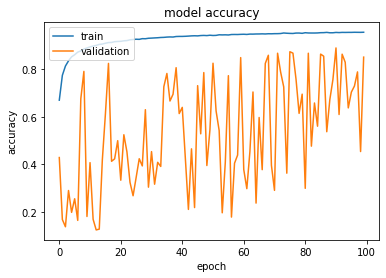

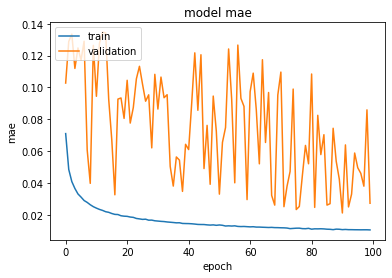

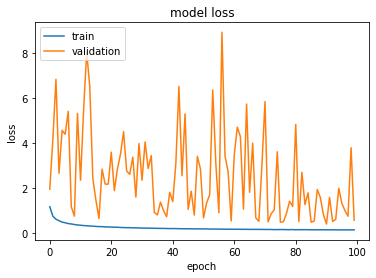

32/32 [==============================] - 1s 23ms/step - loss: 0.5619 - mae: 0.0265 - accuracy: 0.8558

Evaluation:
Loss, MAE, Accuracy [0.5618801712989807, 0.026499750092625618, 0.8558375239372253]
PSDS (0.06832077202093192, 'Valid file')

Filling post processing used.
PSDS (0.6190099976198065, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 7000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 7000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 51s 67ms/step - loss: 1.4277 - mae: 0.0865 - accuracy: 0.6259 - val_loss: 1.6599 - val_mae: 0.1077 - val_accuracy: 0.4655

Epoch 00001: val_loss improved from inf to 1.65990, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.7973 - mae: 0.0509 - accuracy: 0.7634 - val_loss: 2.0234 - val_mae: 0.0994 - val_accuracy: 0.3968

Epoch 00002: val_loss did not improve from 1.65990
Epoch 3/100
480/480 [==============================] - 26s 55ms/step - loss: 0.6403 - mae: 0.0423 - accuracy: 0.8052 - val_loss: 2.3715 - val_mae: 0.0980 - val_accuracy: 0.3821

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.79934
Epoch 35/100
480/480 [==============================] - 28s 59ms/step - loss: 0.2059 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 0.6626 - val_mae: 0.0356 - val_accuracy: 0.8064

Epoch 00035: val_loss improved from 0.79934 to 0.66257, saving model to model.h5
Epoch 36/100
480/480 [==============================] - 29s 61ms/step - loss: 0.2047 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 2.6691 - val_mae: 0.0909 - val_accuracy: 0.4253

Epoch 00036: val_loss did not improve from 0.66257
Epoch 37/100
480/480 [==============================] - 31s 65ms/step - loss: 0.2071 - mae: 0.0147 - accuracy: 0.9357 - val_loss: 1.4123 - val_mae: 0.0578 - val_accuracy: 0.6623

Epoch 00037: val_loss did not improve from 0.66257
Epoch 38/100
480/480 [==============================] - 34s 71ms/step - loss: 0.2008 - mae: 0.0144 - accuracy: 0.9372 - val_loss: 0.4805 - val_mae: 0.0253 - val_accuracy: 0.8670

Epoch 00038: val_loss improved from 0.66257 to 0.

480/480 [==============================] - 30s 63ms/step - loss: 0.1575 - mae: 0.0115 - accuracy: 0.9501 - val_loss: 1.9634 - val_mae: 0.0781 - val_accuracy: 0.5099

Epoch 00070: val_loss did not improve from 0.48055
Epoch 71/100
480/480 [==============================] - 30s 63ms/step - loss: 0.1572 - mae: 0.0115 - accuracy: 0.9504 - val_loss: 1.5392 - val_mae: 0.0565 - val_accuracy: 0.6624

Epoch 00071: val_loss did not improve from 0.48055
Epoch 72/100
480/480 [==============================] - 29s 60ms/step - loss: 0.1583 - mae: 0.0115 - accuracy: 0.9499 - val_loss: 0.6709 - val_mae: 0.0329 - val_accuracy: 0.8189

Epoch 00072: val_loss did not improve from 0.48055
Epoch 73/100
480/480 [==============================] - 28s 57ms/step - loss: 0.1585 - mae: 0.0116 - accuracy: 0.9493 - val_loss: 1.9647 - val_mae: 0.0788 - val_accuracy: 0.5083

Epoch 00073: val_loss did not improve from 0.48055
Epoch 74/100
480/480 [==============================] - 28s 59ms/step - loss: 0.1523 - mae: 0

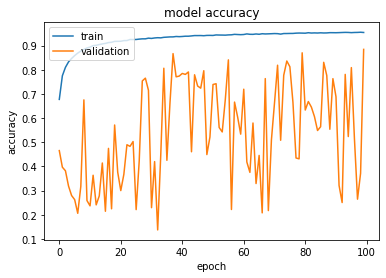

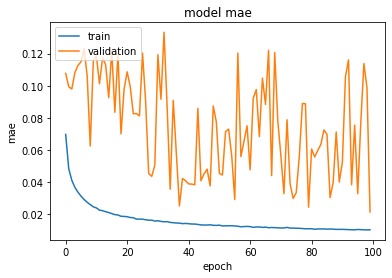

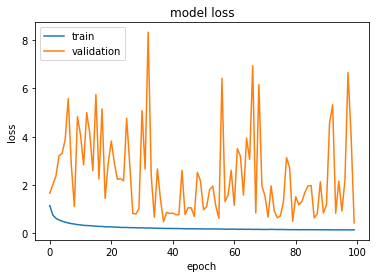

32/32 [==============================] - 1s 25ms/step - loss: 0.4251 - mae: 0.0213 - accuracy: 0.8853

Evaluation:
Loss, MAE, Accuracy [0.4250914752483368, 0.021339701488614082, 0.8853437304496765]
PSDS (0.16436747601617552, 'Valid file')

Filling post processing used.
PSDS (0.7340509283303203, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (7000, 8000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 7000 to 8000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 57s 76ms/step - loss: 1.4364 - mae: 0.0868 - accuracy: 0.6136 - val_loss: 1.3103 - val_mae: 0.0850 - val_accuracy: 0.5944

Epoch 00001: val_loss improved from inf to 1.31031, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 29s 60ms/step - loss: 0.7842 - mae: 0.0498 - accuracy: 0.7678 - val_loss: 5.6406 - val_mae: 0.1329 - val_accuracy: 0.1411

Epoch 00002: val_loss did not improve from 1.31031
Epoch 3/100
480/480 [==============================] - 28s 59ms/step - loss: 0.6408 - mae: 0.0419 - accuracy: 0.8067 - val_loss: 1.5822 - val_mae: 0.0837 - val_accuracy: 0.5115

Epoch 00003: 


Epoch 00034: val_loss did not improve from 0.53640
Epoch 35/100
480/480 [==============================] - 27s 57ms/step - loss: 0.2045 - mae: 0.0146 - accuracy: 0.9370 - val_loss: 1.1762 - val_mae: 0.0568 - val_accuracy: 0.6716

Epoch 00035: val_loss did not improve from 0.53640
Epoch 36/100
480/480 [==============================] - 29s 60ms/step - loss: 0.2093 - mae: 0.0150 - accuracy: 0.9351 - val_loss: 4.1288 - val_mae: 0.0946 - val_accuracy: 0.3936

Epoch 00036: val_loss did not improve from 0.53640
Epoch 37/100
480/480 [==============================] - 28s 58ms/step - loss: 0.2052 - mae: 0.0146 - accuracy: 0.9364 - val_loss: 2.4485 - val_mae: 0.0847 - val_accuracy: 0.4704

Epoch 00037: val_loss did not improve from 0.53640
Epoch 38/100
480/480 [==============================] - 28s 59ms/step - loss: 0.2066 - mae: 0.0149 - accuracy: 0.9353 - val_loss: 1.0283 - val_mae: 0.0455 - val_accuracy: 0.7429

Epoch 00038: val_loss did not improve from 0.53640
Epoch 39/100
480/480 [======

480/480 [==============================] - 27s 56ms/step - loss: 0.1548 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 2.4437 - val_mae: 0.0751 - val_accuracy: 0.5290

Epoch 00070: val_loss did not improve from 0.42256
Epoch 71/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1565 - mae: 0.0114 - accuracy: 0.9507 - val_loss: 4.7959 - val_mae: 0.1105 - val_accuracy: 0.2863

Epoch 00071: val_loss did not improve from 0.42256
Epoch 72/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1580 - mae: 0.0115 - accuracy: 0.9498 - val_loss: 1.7958 - val_mae: 0.0685 - val_accuracy: 0.5820

Epoch 00072: val_loss did not improve from 0.42256
Epoch 73/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1561 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 0.6066 - val_mae: 0.0328 - val_accuracy: 0.8296

Epoch 00073: val_loss did not improve from 0.42256
Epoch 74/100
480/480 [==============================] - 27s 56ms/step - loss: 0.1533 - mae: 0

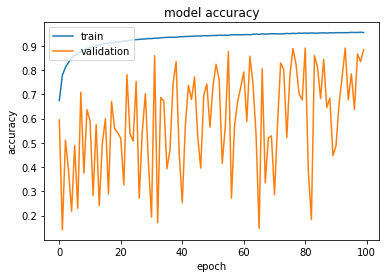

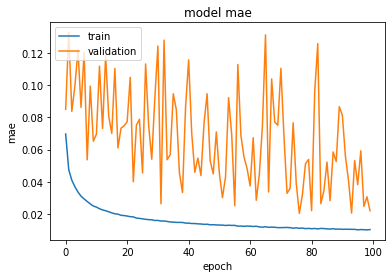

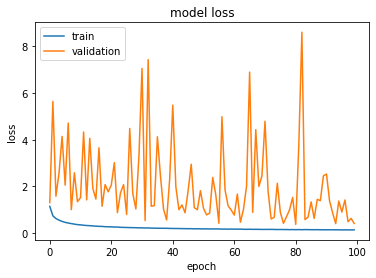

32/32 [==============================] - 1s 25ms/step - loss: 0.4456 - mae: 0.0225 - accuracy: 0.8808

Evaluation:
Loss, MAE, Accuracy [0.4455936849117279, 0.02250111661851406, 0.8807874917984009]
PSDS (0.033016934919108835, 'Valid file')

Filling post processing used.
PSDS (0.7123213337978191, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, 9000)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to 9000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
480/480 [==============================] - 56s 68ms/step - loss: 1.4792 - mae: 0.0893 - accuracy: 0.5987 - val_loss: 1.3994 - val_mae: 0.0895 - val_accuracy: 0.5674

Epoch 00001: val_loss improved from inf to 1.39939, saving model to model.h5
Epoch 2/100
480/480 [==============================] - 27s 56ms/step - loss: 0.8069 - mae: 0.0512 - accuracy: 0.7629 - val_loss: 2.9780 - val_mae: 0.1180 - val_accuracy: 0.2551

Epoch 00002: val_loss did not improve from 1.39939
Epoch 3/100
480/480 [==============================] - 27s 56ms/step - loss: 0.6500 - mae: 0.0424 - accuracy: 0.8070 - val_loss: 3.2430 - val_mae: 0.1172 - val_accuracy: 0.2464

Epoch 00003: 

480/480 [==============================] - 27s 56ms/step - loss: 0.2094 - mae: 0.0149 - accuracy: 0.9345 - val_loss: 0.6688 - val_mae: 0.0335 - val_accuracy: 0.8258

Epoch 00035: val_loss did not improve from 0.49376
Epoch 36/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2081 - mae: 0.0150 - accuracy: 0.9350 - val_loss: 1.6033 - val_mae: 0.0662 - val_accuracy: 0.6033

Epoch 00036: val_loss did not improve from 0.49376
Epoch 37/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2069 - mae: 0.0147 - accuracy: 0.9360 - val_loss: 2.1732 - val_mae: 0.0818 - val_accuracy: 0.4883

Epoch 00037: val_loss did not improve from 0.49376
Epoch 38/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2095 - mae: 0.0150 - accuracy: 0.9346 - val_loss: 0.9889 - val_mae: 0.0401 - val_accuracy: 0.7673

Epoch 00038: val_loss did not improve from 0.49376
Epoch 39/100
480/480 [==============================] - 27s 56ms/step - loss: 0.2081 - mae: 0


Epoch 00070: val_loss did not improve from 0.33796
Epoch 71/100
480/480 [==============================] - 26s 54ms/step - loss: 0.1594 - mae: 0.0116 - accuracy: 0.9496 - val_loss: 1.6598 - val_mae: 0.0617 - val_accuracy: 0.6176

Epoch 00071: val_loss did not improve from 0.33796
Epoch 72/100
480/480 [==============================] - 28s 58ms/step - loss: 0.1562 - mae: 0.0115 - accuracy: 0.9500 - val_loss: 0.6845 - val_mae: 0.0312 - val_accuracy: 0.8310

Epoch 00072: val_loss did not improve from 0.33796
Epoch 73/100
480/480 [==============================] - 26s 55ms/step - loss: 0.1588 - mae: 0.0115 - accuracy: 0.9502 - val_loss: 3.9961 - val_mae: 0.0982 - val_accuracy: 0.3692

Epoch 00073: val_loss did not improve from 0.33796
Epoch 74/100
480/480 [==============================] - 26s 53ms/step - loss: 0.1553 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 2.7269 - val_mae: 0.0891 - val_accuracy: 0.4248

Epoch 00074: val_loss did not improve from 0.33796
Epoch 75/100
480/480 [======

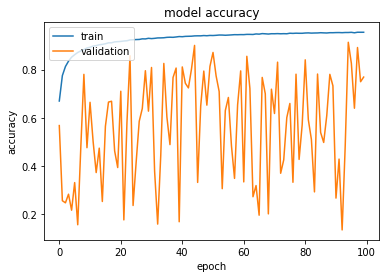

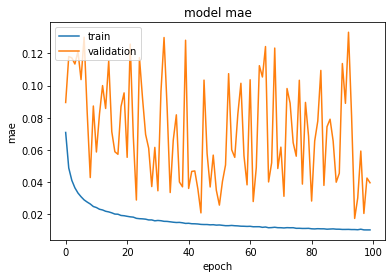

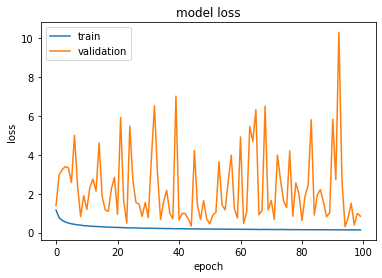

32/32 [==============================] - 3s 41ms/step - loss: 0.8272 - mae: 0.0386 - accuracy: 0.7757

Evaluation:
Loss, MAE, Accuracy [0.8271889686584473, 0.038635581731796265, 0.7757312655448914]
PSDS (0.03703466666666667, 'Valid file')

Filling post processing used.
PSDS (0.6073230266772566, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (9000, -1)
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 59s 85ms/step - loss: 1.5216 - mae: 0.0906 - accuracy: 0.5840 - val_loss: 1.4381 - val_mae: 0.0919 - val_accuracy: 0.5237

Epoch 00001: val_loss improved from inf to 1.43814, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 33s 62ms/step - loss: 0.8018 - mae: 0.0512 - accuracy: 0.7600 - val_loss: 1.0782 - val_mae: 0.0656 - val_accuracy: 0.6986

Epoch 00002: val_loss improved from 1.43814 to 1.07819, saving model to model.h5
Epoch 3/100
534/534 [==============================] - 32s 61ms/step - loss: 0.6435 - mae: 0.0421 - accuracy: 0.8059 - val_loss: 0.8820 - val_mae: 0.0424 - val_accur


Epoch 00034: val_loss did not improve from 0.51294
Epoch 35/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2091 - mae: 0.0149 - accuracy: 0.9353 - val_loss: 2.5337 - val_mae: 0.0890 - val_accuracy: 0.4444

Epoch 00035: val_loss did not improve from 0.51294
Epoch 36/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2172 - mae: 0.0155 - accuracy: 0.9324 - val_loss: 6.0846 - val_mae: 0.1191 - val_accuracy: 0.2272

Epoch 00036: val_loss did not improve from 0.51294
Epoch 37/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2033 - mae: 0.0146 - accuracy: 0.9365 - val_loss: 0.7728 - val_mae: 0.0422 - val_accuracy: 0.7797

Epoch 00037: val_loss did not improve from 0.51294
Epoch 38/100
534/534 [==============================] - 32s 59ms/step - loss: 0.2034 - mae: 0.0146 - accuracy: 0.9367 - val_loss: 1.1797 - val_mae: 0.0500 - val_accuracy: 0.6980

Epoch 00038: val_loss did not improve from 0.51294
Epoch 39/100
534/534 [======

534/534 [==============================] - 32s 59ms/step - loss: 0.1581 - mae: 0.0115 - accuracy: 0.9503 - val_loss: 0.5909 - val_mae: 0.0263 - val_accuracy: 0.8541

Epoch 00070: val_loss did not improve from 0.44834
Epoch 71/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1631 - mae: 0.0119 - accuracy: 0.9485 - val_loss: 1.2120 - val_mae: 0.0527 - val_accuracy: 0.6838

Epoch 00071: val_loss did not improve from 0.44834
Epoch 72/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1608 - mae: 0.0116 - accuracy: 0.9491 - val_loss: 0.5457 - val_mae: 0.0269 - val_accuracy: 0.8555

Epoch 00072: val_loss did not improve from 0.44834
Epoch 73/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1573 - mae: 0.0115 - accuracy: 0.9507 - val_loss: 1.6180 - val_mae: 0.0633 - val_accuracy: 0.6120

Epoch 00073: val_loss did not improve from 0.44834
Epoch 74/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1537 - mae: 0

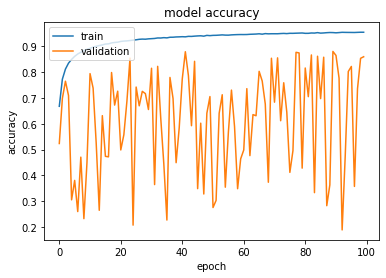

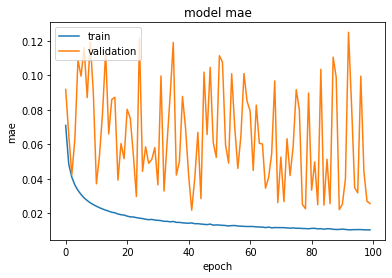

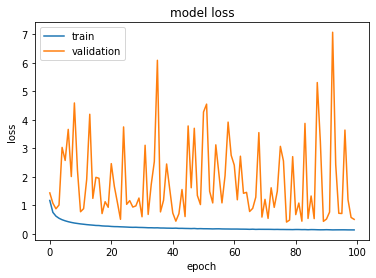

32/32 [==============================] - 1s 24ms/step - loss: 0.5109 - mae: 0.0258 - accuracy: 0.8592 0s - loss: 0.5022 - mae: 0.0251 

Evaluation:
Loss, MAE, Accuracy [0.5109261274337769, 0.025752412155270576, 0.8591716885566711]
PSDS (0.05269816402462206, 'Valid file')

Filling post processing used.
PSDS (0.6678434090732792, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.470390647649765, 2.4635894298553467, 0.6317099332809448, 1.0263255834579468, 2.454240322113037, 0.5618801712989807, 0.4250914752483368, 0.4455936849117279, 0.8271889686584473, 0.5109261274337769]
Mean Loss 0.981693634390831

MAE [0.022938961163163185, 0.07275959849357605, 0.032331548631191254, 0.04243346303701401, 0.08148180693387985, 0.026499750092625618, 0.021339701488614082, 0.02250111661851406, 0.038635581731796265, 0.025752412155270576]
Mean MAE 0.0386673940345645

Accuracy [0.8766531348228455, 0.5439687371253967, 0.8246687650680542, 0.748828113079071, 0.4853406250476837, 0.8558375239372253, 0.8853437304496765, 0.8807874917984009, 0.7757312655448914, 0.8591716885566711]
Mean Accuracy 0.7736331075429916

Model PSDS [0.1382104293622132, 0.062206050219440465, 0.029155510240533467, 0.06403869193581947, 0.05846081408882844, 0.06832077202093192, 0.16436747601617552, 0.033016934919108835, 0.0370346

In [9]:
# cross validation 10 fold val split 0.2
unet_param['val_split_fraction'] = 0.2
test_index_list = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000),
                   (5000, 6000), (6000, 7000), (7000, 8000), (8000, 9000), (9000, -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Test Split: (0, 1000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (0, 1000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 1000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==========================

534/534 [==============================] - 31s 58ms/step - loss: 0.2146 - mae: 0.0153 - accuracy: 0.9331 - val_loss: 0.6512 - val_mae: 0.0339 - val_accuracy: 0.8137

Epoch 00032: val_loss did not improve from 0.58437
Epoch 33/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2128 - mae: 0.0150 - accuracy: 0.9342 - val_loss: 3.4219 - val_mae: 0.1045 - val_accuracy: 0.3275

Epoch 00033: val_loss did not improve from 0.58437
Epoch 34/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2018 - mae: 0.0145 - accuracy: 0.9375 - val_loss: 2.2244 - val_mae: 0.0793 - val_accuracy: 0.4943

Epoch 00034: val_loss did not improve from 0.58437
Epoch 35/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2034 - mae: 0.0145 - accuracy: 0.9366 - val_loss: 1.3844 - val_mae: 0.0684 - val_accuracy: 0.5980

Epoch 00035: val_loss did not improve from 0.58437
Epoch 36/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2032 - mae: 0

534/534 [==============================] - 31s 58ms/step - loss: 0.1555 - mae: 0.0114 - accuracy: 0.9507 - val_loss: 1.7138 - val_mae: 0.0631 - val_accuracy: 0.6072

Epoch 00067: val_loss did not improve from 0.42343
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1555 - mae: 0.0113 - accuracy: 0.9509 - val_loss: 2.3839 - val_mae: 0.0757 - val_accuracy: 0.5234

Epoch 00068: val_loss did not improve from 0.42343
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1565 - mae: 0.0114 - accuracy: 0.9503 - val_loss: 0.9995 - val_mae: 0.0467 - val_accuracy: 0.7253

Epoch 00069: val_loss did not improve from 0.42343
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1564 - mae: 0.0114 - accuracy: 0.9505 - val_loss: 0.9519 - val_mae: 0.0451 - val_accuracy: 0.7422

Epoch 00070: val_loss did not improve from 0.42343
Epoch 71/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1513 - mae: 0

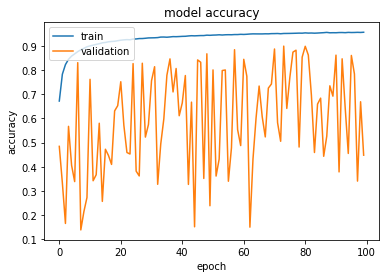

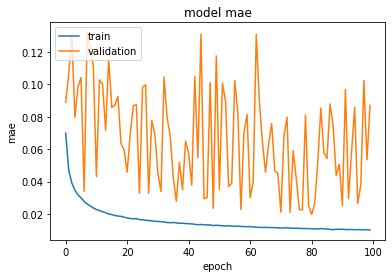

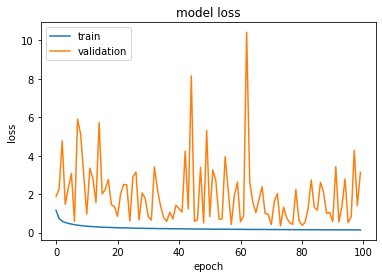

32/32 [==============================] - 1s 23ms/step - loss: 3.0092 - mae: 0.0853 - accuracy: 0.4594

Evaluation:
Loss, MAE, Accuracy [3.009159564971924, 0.08534952253103256, 0.45941561460494995]
PSDS (0.05128172281024561, 'Valid file')

Filling post processing used.
PSDS (0.3345369595349838, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (1000, 2000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (1000, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 1000 to 2000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 30s 57ms/step - loss: 0.2093 - mae: 0.0149 - accuracy: 0.9355 - val_loss: 1.4250 - val_mae: 0.0639 - val_accuracy: 0.6266

Epoch 00031: val_loss did not improve from 0.48563
Epoch 32/100
534/534 [==============================] - 35s 66ms/step - loss: 0.2139 - mae: 0.0152 - accuracy: 0.9341 - val_loss: 3.7741 - val_mae: 0.0919 - val_accuracy: 0.4157

Epoch 00032: val_loss did not improve from 0.48563
Epoch 33/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2045 - mae: 0.0146 - accuracy: 0.9366 - val_loss: 1.1851 - val_mae: 0.0645 - val_accuracy: 0.6457

Epoch 00033: val_loss did not improve from 0.48563
Epoch 34/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2113 - mae: 0.0151 - accuracy: 0.9338 - val_loss: 1.1470 - val_mae: 0.0527 - val_accuracy: 0.6957

Epoch 00034: val_loss did not improve from 0.48563
Epoch 35/100
534/534 [==============================] - 31s 59ms/step - loss: 0.2043 - mae: 0


Epoch 00066: val_loss improved from 0.43597 to 0.32930, saving model to model.h5
Epoch 67/100
534/534 [==============================] - 34s 64ms/step - loss: 0.1515 - mae: 0.0111 - accuracy: 0.9519 - val_loss: 2.7545 - val_mae: 0.0849 - val_accuracy: 0.4605

Epoch 00067: val_loss did not improve from 0.32930
Epoch 68/100
534/534 [==============================] - 34s 65ms/step - loss: 0.1570 - mae: 0.0113 - accuracy: 0.9507 - val_loss: 1.2594 - val_mae: 0.0469 - val_accuracy: 0.7216

Epoch 00068: val_loss did not improve from 0.32930
Epoch 69/100
534/534 [==============================] - 33s 61ms/step - loss: 0.1536 - mae: 0.0112 - accuracy: 0.9515 - val_loss: 2.2064 - val_mae: 0.0776 - val_accuracy: 0.5094

Epoch 00069: val_loss did not improve from 0.32930
Epoch 70/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1591 - mae: 0.0115 - accuracy: 0.9497 - val_loss: 1.7002 - val_mae: 0.0644 - val_accuracy: 0.6190

Epoch 00070: val_loss did not improve from 0.3293

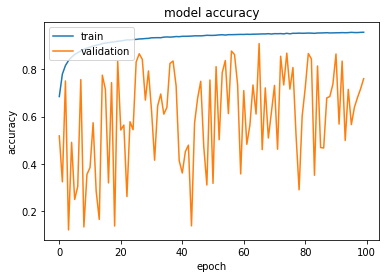

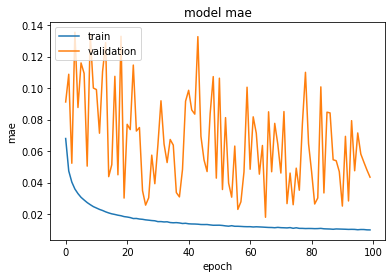

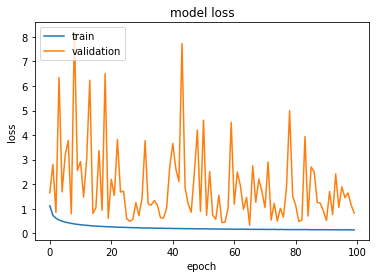

32/32 [==============================] - 1s 28ms/step - loss: 0.8152 - mae: 0.0429 - accuracy: 0.7655

Evaluation:
Loss, MAE, Accuracy [0.8151745200157166, 0.04291342943906784, 0.7655093669891357]
PSDS (0.05106127289354757, 'Valid file')

Filling post processing used.
PSDS (0.4983675714256071, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 3000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (2000, 3000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 3000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 33s 62ms/step - loss: 0.2171 - mae: 0.0155 - accuracy: 0.9326 - val_loss: 1.4694 - val_mae: 0.0562 - val_accuracy: 0.6638

Epoch 00032: val_loss did not improve from 0.40842
Epoch 33/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2107 - mae: 0.0151 - accuracy: 0.9341 - val_loss: 1.4039 - val_mae: 0.0630 - val_accuracy: 0.6166

Epoch 00033: val_loss did not improve from 0.40842
Epoch 34/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2087 - mae: 0.0150 - accuracy: 0.9351 - val_loss: 1.3901 - val_mae: 0.0553 - val_accuracy: 0.6780

Epoch 00034: val_loss did not improve from 0.40842
Epoch 35/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2106 - mae: 0.0150 - accuracy: 0.9343 - val_loss: 2.2854 - val_mae: 0.0827 - val_accuracy: 0.4854

Epoch 00035: val_loss did not improve from 0.40842
Epoch 36/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2047 - mae: 0


Epoch 00067: val_loss did not improve from 0.40842
Epoch 68/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1586 - mae: 0.0116 - accuracy: 0.9497 - val_loss: 2.2944 - val_mae: 0.0688 - val_accuracy: 0.5751

Epoch 00068: val_loss did not improve from 0.40842
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1514 - mae: 0.0112 - accuracy: 0.9518 - val_loss: 2.6663 - val_mae: 0.0845 - val_accuracy: 0.4680

Epoch 00069: val_loss did not improve from 0.40842
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1620 - mae: 0.0118 - accuracy: 0.9486 - val_loss: 0.7951 - val_mae: 0.0388 - val_accuracy: 0.7887

Epoch 00070: val_loss did not improve from 0.40842
Epoch 71/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1602 - mae: 0.0116 - accuracy: 0.9495 - val_loss: 0.6157 - val_mae: 0.0321 - val_accuracy: 0.8301

Epoch 00071: val_loss did not improve from 0.40842
Epoch 72/100
534/534 [======

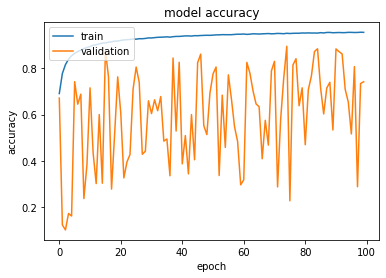

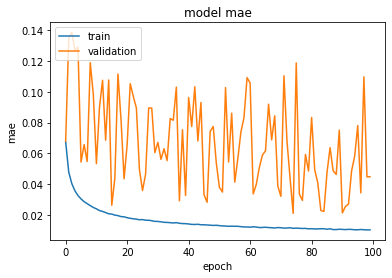

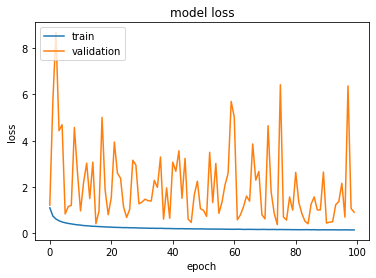

32/32 [==============================] - 1s 27ms/step - loss: 0.9084 - mae: 0.0457 - accuracy: 0.7344

Evaluation:
Loss, MAE, Accuracy [0.9084075093269348, 0.045700233429670334, 0.7344375252723694]
PSDS (0.11239464104302253, 'Valid file')

Filling post processing used.
PSDS (0.5291045526858386, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (3000, 4000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (3000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 3000 to 4000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 32s 61ms/step - loss: 0.2153 - mae: 0.0153 - accuracy: 0.9337 - val_loss: 3.4398 - val_mae: 0.0983 - val_accuracy: 0.3728

Epoch 00031: val_loss did not improve from 0.73807
Epoch 32/100
534/534 [==============================] - 33s 61ms/step - loss: 0.2181 - mae: 0.0154 - accuracy: 0.9338 - val_loss: 0.9993 - val_mae: 0.0426 - val_accuracy: 0.7558

Epoch 00032: val_loss did not improve from 0.73807
Epoch 33/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2112 - mae: 0.0150 - accuracy: 0.9348 - val_loss: 1.0920 - val_mae: 0.0566 - val_accuracy: 0.6905

Epoch 00033: val_loss did not improve from 0.73807
Epoch 34/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2159 - mae: 0.0153 - accuracy: 0.9335 - val_loss: 3.8461 - val_mae: 0.0975 - val_accuracy: 0.3795

Epoch 00034: val_loss did not improve from 0.73807
Epoch 35/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2039 - mae: 0


Epoch 00066: val_loss did not improve from 0.47266
Epoch 67/100
534/534 [==============================] - 33s 63ms/step - loss: 0.1577 - mae: 0.0115 - accuracy: 0.9502 - val_loss: 0.7912 - val_mae: 0.0368 - val_accuracy: 0.7978

Epoch 00067: val_loss did not improve from 0.47266
Epoch 68/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1617 - mae: 0.0117 - accuracy: 0.9494 - val_loss: 2.6524 - val_mae: 0.0798 - val_accuracy: 0.4979

Epoch 00068: val_loss did not improve from 0.47266
Epoch 69/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1602 - mae: 0.0116 - accuracy: 0.9494 - val_loss: 1.1707 - val_mae: 0.0439 - val_accuracy: 0.7406

Epoch 00069: val_loss did not improve from 0.47266
Epoch 70/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1606 - mae: 0.0117 - accuracy: 0.9491 - val_loss: 4.4473 - val_mae: 0.0965 - val_accuracy: 0.3847

Epoch 00070: val_loss did not improve from 0.47266
Epoch 71/100
534/534 [======

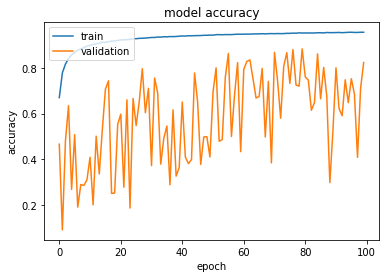

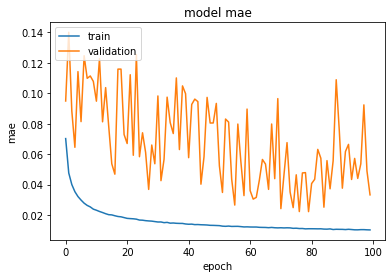

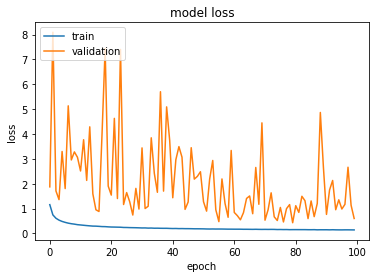

32/32 [==============================] - 1s 28ms/step - loss: 0.6103 - mae: 0.0335 - accuracy: 0.8219

Evaluation:
Loss, MAE, Accuracy [0.6103496551513672, 0.03353607654571533, 0.8219468593597412]
PSDS (0.07955555661577608, 'Valid file')

Filling post processing used.
PSDS (0.5787734202855893, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 5000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (4000, 5000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 5000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 33s 62ms/step - loss: 0.2245 - mae: 0.0159 - accuracy: 0.9301 - val_loss: 1.0964 - val_mae: 0.0528 - val_accuracy: 0.7080

Epoch 00031: val_loss did not improve from 0.67991
Epoch 32/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2213 - mae: 0.0157 - accuracy: 0.9317 - val_loss: 3.7937 - val_mae: 0.1131 - val_accuracy: 0.2708

Epoch 00032: val_loss did not improve from 0.67991
Epoch 33/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2164 - mae: 0.0154 - accuracy: 0.9326 - val_loss: 0.7890 - val_mae: 0.0413 - val_accuracy: 0.7766

Epoch 00033: val_loss did not improve from 0.67991
Epoch 34/100
534/534 [==============================] - 33s 62ms/step - loss: 0.2133 - mae: 0.0151 - accuracy: 0.9343 - val_loss: 0.6675 - val_mae: 0.0318 - val_accuracy: 0.8210

Epoch 00034: val_loss improved from 0.67991 to 0.66745, saving model to model.h5
Epoch 35/100
534/534 [==============================] - 33s 62m

534/534 [==============================] - 33s 62ms/step - loss: 0.1639 - mae: 0.0119 - accuracy: 0.9481 - val_loss: 0.7349 - val_mae: 0.0390 - val_accuracy: 0.7940

Epoch 00066: val_loss did not improve from 0.37255
Epoch 67/100
534/534 [==============================] - 33s 62ms/step - loss: 0.1580 - mae: 0.0115 - accuracy: 0.9501 - val_loss: 1.2116 - val_mae: 0.0457 - val_accuracy: 0.7329

Epoch 00067: val_loss did not improve from 0.37255
Epoch 68/100
534/534 [==============================] - 33s 63ms/step - loss: 0.1631 - mae: 0.0118 - accuracy: 0.9487 - val_loss: 2.9942 - val_mae: 0.0933 - val_accuracy: 0.4026

Epoch 00068: val_loss did not improve from 0.37255
Epoch 69/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1596 - mae: 0.0116 - accuracy: 0.9498 - val_loss: 0.7991 - val_mae: 0.0361 - val_accuracy: 0.8004

Epoch 00069: val_loss did not improve from 0.37255
Epoch 70/100
534/534 [==============================] - 33s 62ms/step - loss: 0.1606 - mae: 0

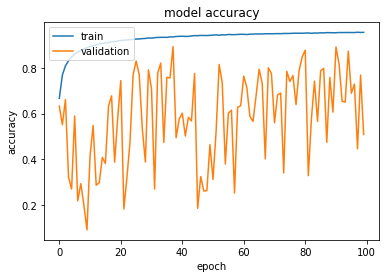

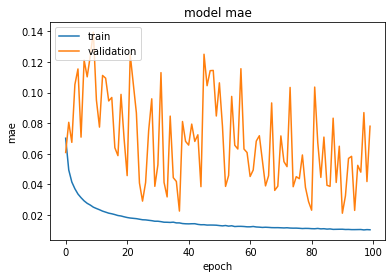

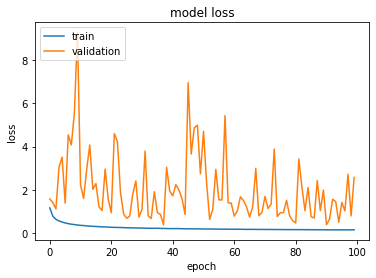

32/32 [==============================] - 1s 26ms/step - loss: 2.5282 - mae: 0.0770 - accuracy: 0.5157

Evaluation:
Loss, MAE, Accuracy [2.528195858001709, 0.07700760662555695, 0.5156968832015991]
PSDS (0.055180366590178435, 'Valid file')

Filling post processing used.
PSDS (0.42218884146416774, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (5000, 6000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (5000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 5000 to 6000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00031: val_loss did not improve from 0.54803
Epoch 32/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2221 - mae: 0.0157 - accuracy: 0.9312 - val_loss: 1.7075 - val_mae: 0.0607 - val_accuracy: 0.6350

Epoch 00032: val_loss did not improve from 0.54803
Epoch 33/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2146 - mae: 0.0152 - accuracy: 0.9335 - val_loss: 1.0648 - val_mae: 0.0571 - val_accuracy: 0.6755

Epoch 00033: val_loss did not improve from 0.54803
Epoch 34/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2104 - mae: 0.0150 - accuracy: 0.9353 - val_loss: 0.4553 - val_mae: 0.0286 - val_accuracy: 0.8623

Epoch 00034: val_loss improved from 0.54803 to 0.45533, saving model to model.h5
Epoch 35/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2061 - mae: 0.0147 - accuracy: 0.9361 - val_loss: 5.6983 - val_mae: 0.1196 - val_accuracy: 0.2213

Epoch 00035: val_loss did not improve from 0.4553

534/534 [==============================] - 32s 60ms/step - loss: 0.1611 - mae: 0.0117 - accuracy: 0.9493 - val_loss: 5.4923 - val_mae: 0.1050 - val_accuracy: 0.3243

Epoch 00067: val_loss did not improve from 0.36021
Epoch 68/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1692 - mae: 0.0122 - accuracy: 0.9467 - val_loss: 2.9336 - val_mae: 0.0840 - val_accuracy: 0.4671

Epoch 00068: val_loss did not improve from 0.36021
Epoch 69/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1673 - mae: 0.0120 - accuracy: 0.9477 - val_loss: 0.5856 - val_mae: 0.0328 - val_accuracy: 0.8313

Epoch 00069: val_loss did not improve from 0.36021
Epoch 70/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1619 - mae: 0.0117 - accuracy: 0.9490 - val_loss: 0.9114 - val_mae: 0.0462 - val_accuracy: 0.7429

Epoch 00070: val_loss did not improve from 0.36021
Epoch 71/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1616 - mae: 0

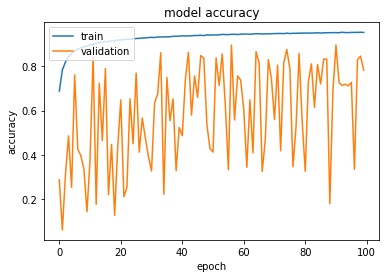

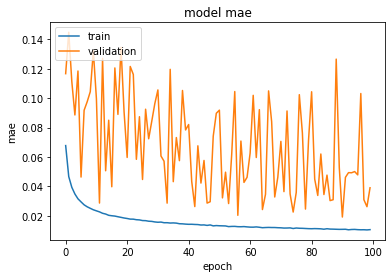

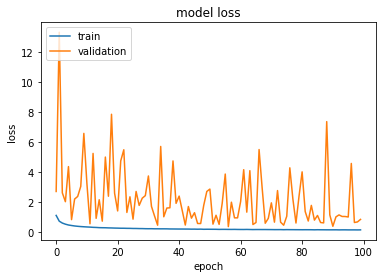

32/32 [==============================] - 1s 25ms/step - loss: 0.9050 - mae: 0.0410 - accuracy: 0.7711

Evaluation:
Loss, MAE, Accuracy [0.9049724340438843, 0.04102083668112755, 0.7711374759674072]
PSDS (0.06597354901950468, 'Valid file')

Filling post processing used.
PSDS (0.4799521823599712, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 7000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (6000, 7000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 7000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 32s 60ms/step - loss: 0.2132 - mae: 0.0152 - accuracy: 0.9336 - val_loss: 1.8140 - val_mae: 0.0756 - val_accuracy: 0.5172

Epoch 00031: val_loss did not improve from 0.51672
Epoch 32/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2121 - mae: 0.0152 - accuracy: 0.9343 - val_loss: 4.8945 - val_mae: 0.1057 - val_accuracy: 0.3189

Epoch 00032: val_loss did not improve from 0.51672
Epoch 33/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2061 - mae: 0.0147 - accuracy: 0.9359 - val_loss: 1.0748 - val_mae: 0.0533 - val_accuracy: 0.6964

Epoch 00033: val_loss did not improve from 0.51672
Epoch 34/100
534/534 [==============================] - 32s 59ms/step - loss: 0.1998 - mae: 0.0143 - accuracy: 0.9383 - val_loss: 0.5947 - val_mae: 0.0293 - val_accuracy: 0.8433

Epoch 00034: val_loss did not improve from 0.51672
Epoch 35/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1977 - mae: 0


Epoch 00066: val_loss did not improve from 0.33490
Epoch 67/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1572 - mae: 0.0115 - accuracy: 0.9497 - val_loss: 2.6444 - val_mae: 0.0800 - val_accuracy: 0.4988

Epoch 00067: val_loss did not improve from 0.33490
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1536 - mae: 0.0113 - accuracy: 0.9513 - val_loss: 2.9905 - val_mae: 0.0881 - val_accuracy: 0.4370

Epoch 00068: val_loss did not improve from 0.33490
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1591 - mae: 0.0116 - accuracy: 0.9494 - val_loss: 0.9292 - val_mae: 0.0454 - val_accuracy: 0.7407

Epoch 00069: val_loss did not improve from 0.33490
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1515 - mae: 0.0112 - accuracy: 0.9517 - val_loss: 0.9206 - val_mae: 0.0478 - val_accuracy: 0.7309

Epoch 00070: val_loss did not improve from 0.33490
Epoch 71/100
534/534 [======

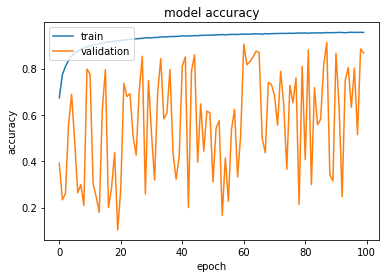

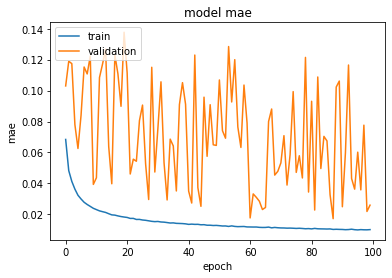

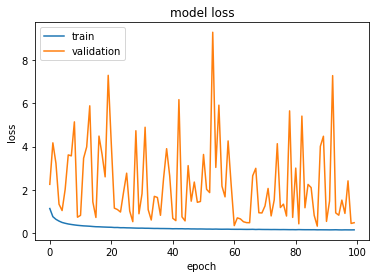

32/32 [==============================] - 1s 24ms/step - loss: 0.4772 - mae: 0.0261 - accuracy: 0.8655

Evaluation:
Loss, MAE, Accuracy [0.47723954916000366, 0.02613430842757225, 0.8654500246047974]
PSDS (0.11502392197142347, 'Valid file')

Filling post processing used.
PSDS (0.6876567642213998, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (7000, 8000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (7000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 7000 to 8000 from dev set.
Existing model.h5 removed.
Tensorfl


Epoch 00031: val_loss did not improve from 0.56042
Epoch 32/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2225 - mae: 0.0157 - accuracy: 0.9313 - val_loss: 0.6773 - val_mae: 0.0383 - val_accuracy: 0.8042

Epoch 00032: val_loss did not improve from 0.56042
Epoch 33/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2184 - mae: 0.0154 - accuracy: 0.9324 - val_loss: 1.6619 - val_mae: 0.0744 - val_accuracy: 0.5472

Epoch 00033: val_loss did not improve from 0.56042
Epoch 34/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2101 - mae: 0.0151 - accuracy: 0.9348 - val_loss: 0.6046 - val_mae: 0.0282 - val_accuracy: 0.8438

Epoch 00034: val_loss did not improve from 0.56042
Epoch 35/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2082 - mae: 0.0148 - accuracy: 0.9354 - val_loss: 2.1694 - val_mae: 0.0796 - val_accuracy: 0.5028

Epoch 00035: val_loss did not improve from 0.56042
Epoch 36/100
534/534 [======

534/534 [==============================] - 31s 58ms/step - loss: 0.1633 - mae: 0.0119 - accuracy: 0.9476 - val_loss: 2.7613 - val_mae: 0.0762 - val_accuracy: 0.5152

Epoch 00067: val_loss did not improve from 0.42749
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1626 - mae: 0.0119 - accuracy: 0.9483 - val_loss: 2.3184 - val_mae: 0.0768 - val_accuracy: 0.5137

Epoch 00068: val_loss did not improve from 0.42749
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1558 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 1.0158 - val_mae: 0.0471 - val_accuracy: 0.7272

Epoch 00069: val_loss did not improve from 0.42749
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1575 - mae: 0.0115 - accuracy: 0.9501 - val_loss: 0.3379 - val_mae: 0.0186 - val_accuracy: 0.9031

Epoch 00070: val_loss improved from 0.42749 to 0.33793, saving model to model.h5
Epoch 71/100
534/534 [==============================] - 31s 58m

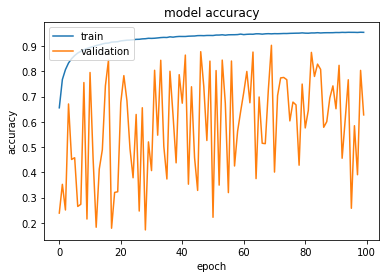

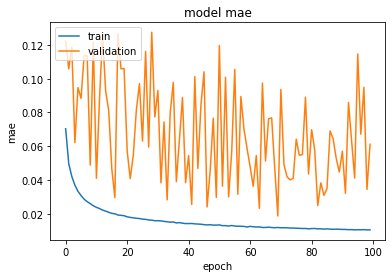

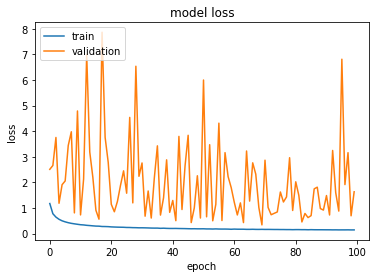

32/32 [==============================] - 1s 24ms/step - loss: 1.6094 - mae: 0.0607 - accuracy: 0.6317

Evaluation:
Loss, MAE, Accuracy [1.6094368696212769, 0.06068430095911026, 0.6317468881607056]
PSDS (0.04141471048513302, 'Valid file')

Filling post processing used.
PSDS (0.4775322754955589, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, 9000)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (8000, 9000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to 9000 from dev set.
Existing model.h5 removed.
Tensorfl

534/534 [==============================] - 31s 58ms/step - loss: 0.2200 - mae: 0.0156 - accuracy: 0.9325 - val_loss: 4.7703 - val_mae: 0.1193 - val_accuracy: 0.2283

Epoch 00031: val_loss did not improve from 0.68630
Epoch 32/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2174 - mae: 0.0154 - accuracy: 0.9331 - val_loss: 0.7566 - val_mae: 0.0377 - val_accuracy: 0.7991

Epoch 00032: val_loss did not improve from 0.68630
Epoch 33/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2133 - mae: 0.0151 - accuracy: 0.9340 - val_loss: 2.2766 - val_mae: 0.0755 - val_accuracy: 0.5382

Epoch 00033: val_loss did not improve from 0.68630
Epoch 34/100
534/534 [==============================] - 31s 58ms/step - loss: 0.2140 - mae: 0.0152 - accuracy: 0.9337 - val_loss: 0.5750 - val_mae: 0.0308 - val_accuracy: 0.8411

Epoch 00034: val_loss improved from 0.68630 to 0.57501, saving model to model.h5
Epoch 35/100
534/534 [==============================] - 31s 58m

534/534 [==============================] - 31s 58ms/step - loss: 0.1576 - mae: 0.0115 - accuracy: 0.9505 - val_loss: 4.6074 - val_mae: 0.1038 - val_accuracy: 0.3343

Epoch 00066: val_loss did not improve from 0.37505
Epoch 67/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1643 - mae: 0.0120 - accuracy: 0.9480 - val_loss: 0.5678 - val_mae: 0.0316 - val_accuracy: 0.8333

Epoch 00067: val_loss did not improve from 0.37505
Epoch 68/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1620 - mae: 0.0118 - accuracy: 0.9488 - val_loss: 2.4159 - val_mae: 0.0742 - val_accuracy: 0.5359

Epoch 00068: val_loss did not improve from 0.37505
Epoch 69/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1640 - mae: 0.0120 - accuracy: 0.9483 - val_loss: 1.5020 - val_mae: 0.0657 - val_accuracy: 0.6011

Epoch 00069: val_loss did not improve from 0.37505
Epoch 70/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1534 - mae: 0

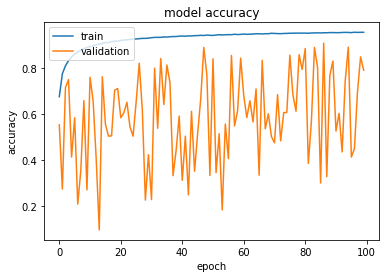

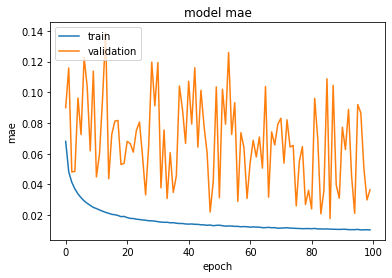

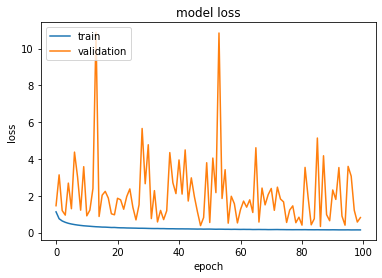

32/32 [==============================] - 1s 24ms/step - loss: 0.8242 - mae: 0.0361 - accuracy: 0.7912

Evaluation:
Loss, MAE, Accuracy [0.8242232203483582, 0.036096345633268356, 0.7912343740463257]
PSDS (0.06772543316249936, 'Valid file')

Filling post processing used.
PSDS (0.46789832506344575, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (9000, -1)
Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow ver


Epoch 00031: val_loss did not improve from 0.53817
Epoch 32/100
593/593 [==============================] - 34s 58ms/step - loss: 0.2016 - mae: 0.0145 - accuracy: 0.9373 - val_loss: 1.7008 - val_mae: 0.0800 - val_accuracy: 0.5041

Epoch 00032: val_loss did not improve from 0.53817
Epoch 33/100
593/593 [==============================] - 35s 58ms/step - loss: 0.1979 - mae: 0.0142 - accuracy: 0.9383 - val_loss: 1.4771 - val_mae: 0.0655 - val_accuracy: 0.6058

Epoch 00033: val_loss did not improve from 0.53817
Epoch 34/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1955 - mae: 0.0139 - accuracy: 0.9389 - val_loss: 3.6216 - val_mae: 0.1013 - val_accuracy: 0.3426

Epoch 00034: val_loss did not improve from 0.53817
Epoch 35/100
593/593 [==============================] - 35s 58ms/step - loss: 0.1943 - mae: 0.0139 - accuracy: 0.9397 - val_loss: 3.2680 - val_mae: 0.0993 - val_accuracy: 0.3635

Epoch 00035: val_loss did not improve from 0.53817
Epoch 36/100
593/593 [======

593/593 [==============================] - 34s 58ms/step - loss: 0.1540 - mae: 0.0112 - accuracy: 0.9514 - val_loss: 1.0920 - val_mae: 0.0546 - val_accuracy: 0.6824

Epoch 00067: val_loss did not improve from 0.39126
Epoch 68/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1508 - mae: 0.0110 - accuracy: 0.9520 - val_loss: 0.9610 - val_mae: 0.0409 - val_accuracy: 0.7560

Epoch 00068: val_loss did not improve from 0.39126
Epoch 69/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1479 - mae: 0.0108 - accuracy: 0.9532 - val_loss: 1.4771 - val_mae: 0.0597 - val_accuracy: 0.6377

Epoch 00069: val_loss did not improve from 0.39126
Epoch 70/100
593/593 [==============================] - 35s 58ms/step - loss: 0.1469 - mae: 0.0108 - accuracy: 0.9535 - val_loss: 3.3148 - val_mae: 0.0882 - val_accuracy: 0.4385

Epoch 00070: val_loss did not improve from 0.39126
Epoch 71/100
593/593 [==============================] - 34s 58ms/step - loss: 0.1472 - mae: 0

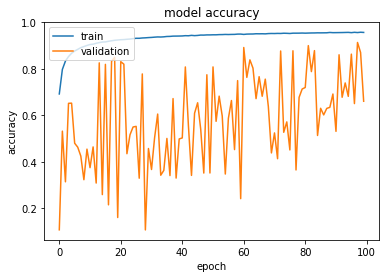

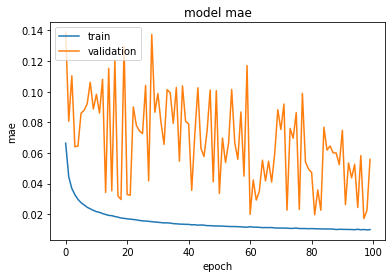

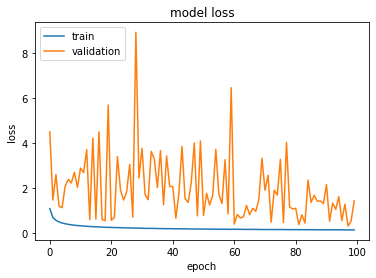

32/32 [==============================] - 1s 24ms/step - loss: 1.4245 - mae: 0.0557 - accuracy: 0.6615 0s - loss: 1.4179 - mae: 0.055

Evaluation:
Loss, MAE, Accuracy [1.4245308637619019, 0.05569107457995415, 0.6615490317344666]
PSDS (0.05115838020735739, 'Valid file')

Filling post processing used.
PSDS (0.4287932378420068, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [3.009159564971924, 0.8151745200157166, 0.9084075093269348, 0.6103496551513672, 2.528195858001709, 0.9049724340438843, 0.47723954916000366, 1.6094368696212769, 0.8242232203483582, 1.4245308637619019]
Mean Loss 1.3111690044403077

MAE [0.08534952253103256, 0.04291342943906784, 0.045700233429670334, 0.03353607654571533, 0.07700760662555695, 0.04102083668112755, 0.02613430842757225, 0.06068430095911026, 0.036096345633268356, 0.05569107457995415]
Mean MAE 0.05041337348520756

Accuracy [0.45941561460494995, 0.7655093669891357, 0.7344375252723694, 0.8219468593597412, 0.5156968832015991, 0.7711374759674072, 0.8654500246047974, 0.6317468881607056, 0.7912343740463257, 0.6615490317344666]
Mean Accuracy 0.7018124043941498

Model PSDS [0.05128172281024561, 0.05106127289354757, 0.11239464104302253, 0.07955555661577608, 0.055180366590178435, 0.06597354901950468, 0.11502392197142347, 0.04141471048513302, 0.0677254

In [22]:
# cross validation 10 fold, val split 0.1, wie submission1
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'
test_index_list = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000),
                   (5000, 6000), (6000, 7000), (7000, 8000), (8000, 9000), (9000, -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

0it [00:00, ?it/s]

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'standard', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Loading dev set:


30044it [07:11, 69.57it/s]


Loading eval set:


3000it [02:31, 19.74it/s]


Scaling files.
Saving to numpy arrays.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 65s 90ms/step - loss: 1.4858 - mae: 0.0890 - accuracy: 0.5947 - val_loss: 1.8053 - val_mae: 0.0966 - val_accuracy: 0.4728

Epoch 00001: val_loss improved from inf to 1.80527, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 31s 57ms/step - loss: 0.7923 - mae: 0.0507 - accuracy: 0.7646 - val_loss: 2.6380 - val_mae: 0.1087 - val_accuracy: 0.3342

Epoch 00002: val_loss did not improve from 1.80527
Epoch 3/100
534/534 [==============================] - 30s 57ms/step - loss: 0.6394 - mae: 0.0421 - accuracy: 0.8061 - val_loss: 3.3822 - val_mae: 0.1160 - val_accuracy: 0.2714

Epoch 00003: val_loss did not improve from 1.80527
Epoch 4/100
534/534 [==============================] - 30s 57ms/step - loss: 0.5543 - mae: 0.0371 - accuracy: 0.8325 - val_loss: 0.9810 - va


Epoch 00035: val_loss did not improve from 0.69126
Epoch 36/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2108 - mae: 0.0150 - accuracy: 0.9344 - val_loss: 3.6473 - val_mae: 0.1024 - val_accuracy: 0.3415

Epoch 00036: val_loss did not improve from 0.69126
Epoch 37/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2043 - mae: 0.0146 - accuracy: 0.9364 - val_loss: 3.2847 - val_mae: 0.1062 - val_accuracy: 0.3161

Epoch 00037: val_loss did not improve from 0.69126
Epoch 38/100
534/534 [==============================] - 31s 57ms/step - loss: 0.2019 - mae: 0.0145 - accuracy: 0.9372 - val_loss: 2.1069 - val_mae: 0.0798 - val_accuracy: 0.5068

Epoch 00038: val_loss did not improve from 0.69126
Epoch 39/100
534/534 [==============================] - 31s 57ms/step - loss: 0.1964 - mae: 0.0142 - accuracy: 0.9388 - val_loss: 2.1644 - val_mae: 0.0706 - val_accuracy: 0.5744

Epoch 00039: val_loss did not improve from 0.69126
Epoch 40/100
534/534 [======

534/534 [==============================] - 33s 62ms/step - loss: 0.1611 - mae: 0.0116 - accuracy: 0.9500 - val_loss: 0.7697 - val_mae: 0.0337 - val_accuracy: 0.8116

Epoch 00071: val_loss did not improve from 0.42636
Epoch 72/100
534/534 [==============================] - 39s 74ms/step - loss: 0.1574 - mae: 0.0114 - accuracy: 0.9505 - val_loss: 0.6935 - val_mae: 0.0354 - val_accuracy: 0.8018

Epoch 00072: val_loss did not improve from 0.42636
Epoch 73/100
534/534 [==============================] - 35s 65ms/step - loss: 0.1557 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 0.5893 - val_mae: 0.0288 - val_accuracy: 0.8424

Epoch 00073: val_loss did not improve from 0.42636
Epoch 74/100
534/534 [==============================] - 32s 61ms/step - loss: 0.1544 - mae: 0.0112 - accuracy: 0.9513 - val_loss: 1.6015 - val_mae: 0.0581 - val_accuracy: 0.6439

Epoch 00074: val_loss did not improve from 0.42636
Epoch 75/100
534/534 [==============================] - 35s 65ms/step - loss: 0.1589 - mae: 0

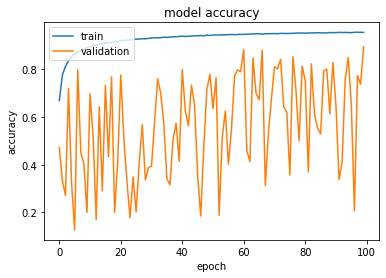

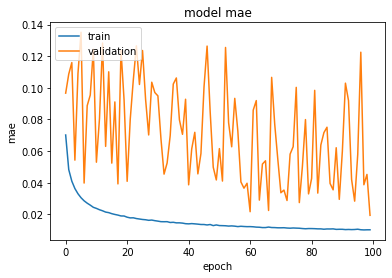

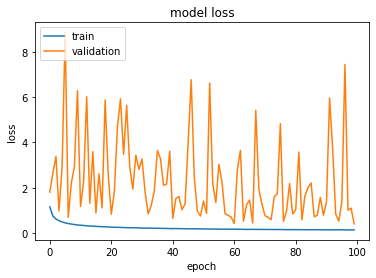

63/63 [==============================] - 2s 28ms/step - loss: 0.4073 - mae: 0.0194 - accuracy: 0.8948

Evaluation:
Loss, MAE, Accuracy [0.40726831555366516, 0.019407635554671288, 0.8947770595550537]
PSDS (0.13540364501391036, 'Valid file')

Filling post processing used.
PSDS (0.7309687965038966, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.40726831555366516, 0.019407635554671288, 0.8947770595550537],
 0.13540364501391036,
 0.7309687965038966)

In [25]:
# scaling
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'standard', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

0it [00:00, ?it/s]

Pipeline parameter: {'data_folder': './../data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'minmax', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Loading dev set:


30044it [08:37, 58.01it/s]


Loading eval set:


3000it [02:21, 21.18it/s]


Scaling files.
Saving to numpy arrays.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
534/534 [==============================] - 69s 107ms/step - loss: 1.4551 - mae: 0.0875 - accuracy: 0.6083 - val_loss: 2.0807 - val_mae: 0.0946 - val_accuracy: 0.4737

Epoch 00001: val_loss improved from inf to 2.08070, saving model to model.h5
Epoch 2/100
534/534 [==============================] - 32s 61ms/step - loss: 0.7808 - mae: 0.0500 - accuracy: 0.7681 - val_loss: 3.9662 - val_mae: 0.1258 - val_accuracy: 0.1969

Epoch 00002: val_loss did not improve from 2.08070
Epoch 3/100
534/534 [==============================] - 32s 61ms/step - loss: 0.6251 - mae: 0.0411 - accuracy: 0.8123 - val_loss: 4.5546 - val_mae: 0.1252 - val_accuracy: 0.1969

Epoch 00003: val_loss did not improve from 2.08070
Epoch 4/100
534/534 [==============================] - 32s 61ms/step - loss: 0.5397 - mae: 0.0360 - accuracy: 0.8384 - val_loss: 3.3928 - v


Epoch 00035: val_loss did not improve from 0.56797
Epoch 36/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2074 - mae: 0.0149 - accuracy: 0.9351 - val_loss: 5.4608 - val_mae: 0.1195 - val_accuracy: 0.2249

Epoch 00036: val_loss did not improve from 0.56797
Epoch 37/100
534/534 [==============================] - 32s 60ms/step - loss: 0.2003 - mae: 0.0143 - accuracy: 0.9381 - val_loss: 0.5422 - val_mae: 0.0269 - val_accuracy: 0.8563

Epoch 00037: val_loss improved from 0.56797 to 0.54225, saving model to model.h5
Epoch 38/100
534/534 [==============================] - 32s 60ms/step - loss: 0.1990 - mae: 0.0142 - accuracy: 0.9380 - val_loss: 1.1639 - val_mae: 0.0579 - val_accuracy: 0.6627

Epoch 00038: val_loss did not improve from 0.54225
Epoch 39/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1918 - mae: 0.0137 - accuracy: 0.9409 - val_loss: 0.6980 - val_mae: 0.0311 - val_accuracy: 0.8270

Epoch 00039: val_loss did not improve from 0.5422

534/534 [==============================] - 32s 59ms/step - loss: 0.1555 - mae: 0.0113 - accuracy: 0.9511 - val_loss: 5.4914 - val_mae: 0.1181 - val_accuracy: 0.2355

Epoch 00071: val_loss did not improve from 0.50721
Epoch 72/100
534/534 [==============================] - 30s 56ms/step - loss: 0.1601 - mae: 0.0116 - accuracy: 0.9492 - val_loss: 3.4159 - val_mae: 0.1013 - val_accuracy: 0.3518

Epoch 00072: val_loss did not improve from 0.50721
Epoch 73/100
534/534 [==============================] - 31s 58ms/step - loss: 0.1565 - mae: 0.0114 - accuracy: 0.9508 - val_loss: 1.6083 - val_mae: 0.0685 - val_accuracy: 0.5830

Epoch 00073: val_loss did not improve from 0.50721
Epoch 74/100
534/534 [==============================] - 33s 61ms/step - loss: 0.1525 - mae: 0.0111 - accuracy: 0.9522 - val_loss: 2.3700 - val_mae: 0.0783 - val_accuracy: 0.5144

Epoch 00074: val_loss did not improve from 0.50721
Epoch 75/100
534/534 [==============================] - 34s 63ms/step - loss: 0.1622 - mae: 0

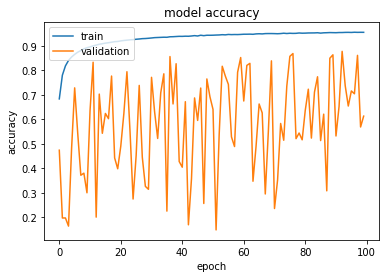

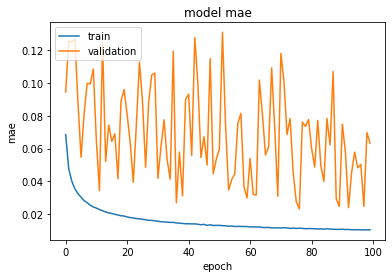

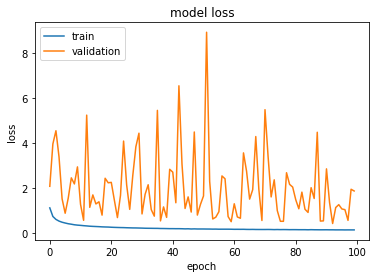

63/63 [==============================] - 2s 24ms/step - loss: 1.8731 - mae: 0.0633 - accuracy: 0.6128

Evaluation:
Loss, MAE, Accuracy [1.8731404542922974, 0.0632973313331604, 0.6127798557281494]
PSDS (0.004044476306394667, 'Valid file')

Filling post processing used.
PSDS (0.24811107875550611, 'Valid file')


/home/alex/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([1.8731404542922974, 0.0632973313331604, 0.6127798557281494],
 0.004044476306394667,
 0.24811107875550611)

In [26]:
# scaling
pipe_param = {'data_folder': './../data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'minmax', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

In [ ]:
# mehrere notebooks laufen genauso schnell?